In [687]:
import numpy as np
from keras.datasets import mnist
from tqdm import tqdm
import numba
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [688]:
from numba import njit, types, vectorize
from numba.extending import overload, register_jitable
from numba.core.errors import TypingError

In [806]:
full = False

In [807]:
if full:
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    train_X = train_X.reshape(-1,784).astype(np.float64)
    test_X = test_X.reshape(-1,784).astype(np.float64)

In [808]:
if not full:
    digits = datasets.load_digits()
    train_X, test_X, train_y, test_y = train_test_split(digits.data, digits.target, test_size=0.4, random_state=4)
    train_X = train_X.reshape(-1,64).astype(np.float64)
    test_X = test_X.reshape(-1,64).astype(np.float64)

In [809]:
samples = train_X.shape[0]
x_dim = train_X.shape[1]
X = train_X.T

In [834]:
num_clusters = 100
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = False
alpha = 10**-2.5
for t in tqdm(range(samples)):
    
    #Initializing Variables
    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = np.zeros(1)

    if neural: ## Neural Step 3
        
        er  = 1
        itr = 1
        
        # Iterate until convergence
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            # Update y and z
            
            y = np.maximum( 0, y + (eta)*(-alpha*t*y/n -a - z - rho*(np.sum(y, axis=0) - 1)) );
            z += eta*(np.sum(y, axis=0) - 1) - 1
            
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else: ## Non-Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]
    
    ## Step 4
    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/min(n[i], 100)

        theta[i] += y[i]*(z - theta[i])/min(n[i], 100)

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

100%|███████████████████████████████████████| 1078/1078 [00:50<00:00, 21.36it/s]


In [835]:
Y = Y.T

In [836]:
Y.shape

(1078, 100)

In [837]:
np.argmax(Y, axis=1)

array([61, 61, 61, ..., 61, 61, 61])

In [838]:
np.mean(np.argmax(Y, axis=1))

61.0

In [829]:
#np.sum(Y[:100], axis=1)

In [792]:
mu1s = []
mu2s = []
wopts = []
for dgt in tqdm(range(10)):
    mu_1 = np.mean(Y[train_y != dgt], axis=0)
    mu_2 = np.mean(Y[train_y == dgt], axis=0)

    Sigma1 = calculate_covariance_matrix(Y[train_y != dgt])
    #Sigma1 = np.cov(Y[train_y != dgt].T)
    Sigma2 = calculate_covariance_matrix(Y[train_y == dgt])
    Sigma = Sigma1# + Sigma2

    w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
    w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)
    obj_opt = (w_opt.T@(mu_1-mu_2))**2
    
    print((np.sum(w_opt.T@Y[train_y != dgt].T > 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@Y[train_y == dgt].T < 1/2 * w_opt.T@(mu_1+mu_2))))/Y.shape[0]*100, (np.sum(w_opt.T@Y[train_y != dgt].T < 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@Y[train_y == dgt].T > 1/2 * w_opt.T@(mu_1+mu_2))))/Y.shape[0]*100)
    
    
    wopts.append(w_opt)
    mu1s.append(mu_1)
    mu2s.append(mu_2)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 504.64it/s]

51.57699443413729 48.42300556586271
52.319109461966605 47.680890538033395
53.98886827458256 46.01113172541744
51.39146567717996 48.608534322820034
51.113172541743964 48.88682745825603
49.35064935064935 50.649350649350644
51.855287569573285 48.144712430426715
53.15398886827458 46.84601113172542
50.18552875695733 49.814471243042675
52.69016697588126 47.30983302411874


In [793]:
d_k = np.array([(w.T@Y.T - (1/2) * w.T@(mu_1+mu_2)) for w, mu_1, mu_2 in zip(wopts, mu1s, mu2s)] ).reshape(10,-1)

In [794]:
np.sum(np.argmin(d_k, axis=0) == train_y)/len(train_y)

0.10482374768089053

In [781]:
# train_X = (train_X >= 3)*1.0
# test_X = (test_X >= 3)*1.0

In [693]:
# train_X = (train_X >= 50)*1.0
# test_X = (test_X >= 50)*1.0

In [694]:
# y = train_X
# digits = train_X.shape[0]

In [695]:
NKCs = 5000
theta_KC = 7
digits = train_X.shape[0]
#NAL = 784
NAL = 64
y = np.zeros((digits,NKCs))
c = np.random.binomial(1, 0.1, NAL*NKCs).reshape(NKCs, NAL).astype(np.float64)
        
    

In [696]:
@vectorize
def _heaviside(x1, x2):
    """ vectorized implementation of the heaviside function """
    if np.isnan(x1):
        return np.nan
    elif x1 == 0:
        return x2
    elif x1 < 0:
        return 0.0
    else:
        return 1.0


@overload(np.heaviside)
def np_heaviside(x1, x2):

    def heaviside_impl(x1, x2):
        """ numba implementation of the heaviside function """
        return _heaviside(x1, x2)

    return heaviside_impl

In [697]:
@numba.jit(nopython=True)
def get_y(c, X, k):
    return np.heaviside(c.dot(X[k]) - theta_KC, 1)

In [698]:
for k in tqdm(range(digits)):
    y[k] = get_y(c, train_X, k)

100%|█████████████████████████████████████| 1078/1078 [00:00<00:00, 4754.91it/s]


In [699]:
#np.save("y.npy", y)
#y = np.load("y.npy")

In [700]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)


In [701]:
Y = np.zeros((10, digits))

for i in range(10):
    for k in range(digits):
        Y[i, k] = 1 if train_y[k] == i else 0

In [702]:
np.sum(train_y == 2)

105

In [703]:
np.sum(Y[2])

105.0

In [704]:
# ws = []
# for dgt in [2]:
#     mu_1 = np.mean(y[train_y != dgt], axis=0)
#     mu_2 = np.mean(y[train_y == dgt], axis=0)

#     Sigma1 = calculate_covariance_matrix(y[train_y != dgt])
#     Sigma2 = calculate_covariance_matrix(y[train_y == dgt])
#     Sigma = Sigma1#+Sigma2

#     w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
#     w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)
#     obj_opt = (w_opt.T@(mu_1-mu_2))**2

#     plt.scatter(w_opt.T@y[train_y != dgt].T,np.zeros((w_opt.T@y[train_y != dgt].T).shape),s=5)
#     plt.scatter(w_opt.T@y[train_y == dgt].T,np.zeros((w_opt.T@y[train_y == dgt].T).shape),s=5)
#     plt.grid()
#     plt.title("Optimal Projection")
#     plt.show()
    
#     print(max(np.sum(w_opt.T@y[train_y != dgt].T > 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T < 1/2 * w_opt.T@(mu_1+mu_2))), np.sum(w_opt.T@y[train_y != dgt].T < 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T > 1/2 * w_opt.T@(mu_1+mu_2))))/y.shape[0]*100)
    
#     eta = 0.1; gam = 0.0001*eta; iters = 1000000
    
#     obj = np.zeros(iters)
#     err = np.zeros(iters)

#     @numba.jit(nopython=True)
#     def fit(w, l, mu_1, mu_2, Sigma):
#         w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
#         l = l + gam*((w.T@Sigma@w).item() - 1)

#         return w, l

#     def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):

#         w = np.random.randn(NKCs,1)/np.sqrt(NKCs)
#         l = 1

#         for i_iter in tqdm(range(iters)):
#             w, l = fit(w, l, mu_1, mu_2, Sigma)
#             obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
#             err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

#         return w
    
    
#     w = run_offline(mu_1[:,None], mu_2[:,None], Sigma, eta, gam, iters)
#     ws.append(w)
    
#     plt.loglog(range(iters), err)
#     plt.ylabel("Error")
#     plt.xlabel("t")
#     plt.title("Offline convergence")
#     plt.show()
    
#     print(err[-1])
    
#     plt.scatter(w.T@y[train_y != dgt].T,np.zeros((w.T@y[train_y != dgt].T).shape),s=5)
#     plt.scatter(w.T@y[train_y == dgt].T,np.zeros((w.T@y[train_y == dgt].T).shape),s=5)
#     plt.grid()
#     plt.title("Offline Projection")
#     plt.show()
    
#     print(max(np.sum(w.T@y[train_y != dgt].T > 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T > 1/2 * w.T@(mu_1+mu_2))), np.sum(w.T@y[train_y != dgt].T < 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T < 1/2 * w.T@(mu_1+mu_2))))/y.shape[0]*100)

In [705]:
#  print(max(np.sum(w.T@y[train_y != dgt].T > 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T < 1/2 * w.T@(mu_1+mu_2))), np.sum(w.T@y[train_y != dgt].T < 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T > 1/2 * w.T@(mu_1+mu_2))))/y.shape[0]*100)

In [706]:
mu1s = []
mu2s = []
wopts = []
for dgt in tqdm(range(10)):
    mu_1 = np.mean(y[train_y != dgt], axis=0)
    mu_2 = np.mean(y[train_y == dgt], axis=0)

    Sigma1 = calculate_covariance_matrix(y[train_y != dgt])
    Sigma2 = calculate_covariance_matrix(y[train_y == dgt])
    Sigma = Sigma1

    w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
    w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)
    obj_opt = (w_opt.T@(mu_1-mu_2))**2
    
    print((np.sum(w_opt.T@y[train_y != dgt].T > 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T < 1/2 * w_opt.T@(mu_1+mu_2))))/y.shape[0]*100, (np.sum(w_opt.T@y[train_y != dgt].T < 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T > 1/2 * w_opt.T@(mu_1+mu_2))))/y.shape[0]*100)
    
    
    wopts.append(w_opt)
    mu1s.append(mu_1)
    mu2s.append(mu_2)

 10%|████▍                                       | 1/10 [00:52<07:55, 52.86s/it]

96.93877551020408 3.061224489795918


 20%|████████▊                                   | 2/10 [01:48<07:17, 54.74s/it]

94.71243042671614 5.287569573283859


 30%|█████████████▏                              | 3/10 [02:47<06:34, 56.41s/it]

95.73283858998145 4.267161410018553


 40%|█████████████████▌                          | 4/10 [03:40<05:30, 55.15s/it]

96.38218923933209 3.6178107606679033


 50%|██████████████████████                      | 5/10 [04:36<04:36, 55.37s/it]

96.19666048237477 3.803339517625232


 60%|██████████████████████████▍                 | 6/10 [05:29<03:38, 54.58s/it]

95.26901669758813 4.7309833024118735


 70%|██████████████████████████████▊             | 7/10 [06:20<02:40, 53.36s/it]

96.93877551020408 3.061224489795918


 80%|███████████████████████████████████▏        | 8/10 [07:13<01:46, 53.23s/it]

96.19666048237477 3.803339517625232


 90%|███████████████████████████████████████▌    | 9/10 [08:05<00:53, 53.09s/it]

93.59925788497218 6.40074211502783


100%|███████████████████████████████████████████| 10/10 [08:59<00:00, 53.96s/it]

95.45454545454545 4.545454545454546


In [707]:
d_k = np.array([(w.T@y.T - (1/2) * w.T@(mu_1+mu_2)) for w, mu_1, mu_2 in zip(wopts, mu1s, mu2s)] ).reshape(10,-1)

In [708]:
d_k[:10,:5]

array([[ 70.96363801,  72.53872807,  72.16982142,  68.73816331,
         72.51582572],
       [ 11.64805844,  12.77310468,  12.27163587,  11.44950325,
          2.52217548],
       [ 28.63441527,  29.50491473,  29.42851251,  30.08214977,
         28.71299341],
       [ 13.69433541,  14.45157992,  14.49643808,  15.07596059,
         13.08883703],
       [ 31.87695252, -25.64043856,  31.66607639,  32.20403412,
         31.7591022 ],
       [ 29.20227562,  30.34170096,  29.81859691,  27.49669006,
         29.56450616],
       [  7.5478768 ,  39.39192445,  38.78224684,  38.97463217,
         37.36190099],
       [ 17.50026059,  20.29355777,   7.80859935,   5.4378869 ,
         20.35077782],
       [ 28.87728473,  27.8454328 ,  27.62533801,  28.86075605,
         26.25940566],
       [ 27.27555191,  27.89048872,  28.07926864,  28.89275033,
         27.32933604]])

In [712]:
np.argmin(d_k, axis=0)

array([6, 4, 7, ..., 8, 1, 1])

In [713]:
np.sum(np.argmin(d_k, axis=0) == train_y)/len(train_y)

0.7606679035250464

In [714]:
train_y

array([6, 4, 7, ..., 8, 7, 9])

In [110]:
e1 = 1e-3
e2 = 1e2
@numba.jit(nopython=True)
def eta(t):
    return e1#/(1+t/e2)
gam = 0.001; epochs = 1000; iters = epochs*digits
samples = digits

In [25]:
from tqdm import trange

In [26]:
@numba.jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t):
    wx = w.T@x
    z = wx
    
    step = eta(t)
    
    if y == 0:
        mu += (x - mu)/t
        zeta += (z-zeta)/t
        w += step*(mu - l*(z-zeta)*(x-mu))
        l += gam*step*((z-zeta)**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_


tr = trange(epochs, desc='', leave=True)
    
    
def run_bio(X, Y):
    
    w = np.random.randn(NKCs)/np.sqrt(NKCs)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(NKCs)

    for i_epoch in tr:

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t)
            
            obj[i_iter] = (w.T@(mu_1[:, None]-mu_2[:, None]))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
            #tr.set_description("err %1.3f" % (abs(obj_opt - obj[i_iter])/obj_opt))
            #tr.refresh() # to show immediately the update
        
        print(f'Error: {err[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)


w = run_bio(y.T,Y[dgt-1])
np.save("w.npy", w)

  0%|                                          | 1/1000 [00:03<57:55,  3.48s/it]

Error: 0.7830104622177979


  0%|                                          | 2/1000 [00:06<50:11,  3.02s/it]

Error: 0.7508950008599916


  0%|▏                                         | 3/1000 [00:08<46:06,  2.77s/it]

Error: 0.7272936776821358


  0%|▏                                         | 4/1000 [00:11<48:10,  2.90s/it]

Error: 0.7153158969267629


  0%|▏                                         | 5/1000 [00:14<48:00,  2.89s/it]

Error: 0.7001977596625258


  1%|▎                                         | 6/1000 [00:17<46:10,  2.79s/it]

Error: 0.6890085180258947


  1%|▎                                         | 7/1000 [00:20<46:54,  2.83s/it]

Error: 0.6787895253924037


  1%|▎                                         | 8/1000 [00:22<45:46,  2.77s/it]

Error: 0.6706183662845306


  1%|▍                                         | 9/1000 [00:25<47:06,  2.85s/it]

Error: 0.6611937375693763


  1%|▍                                        | 10/1000 [00:28<45:42,  2.77s/it]

Error: 0.660781852197373


  1%|▍                                        | 11/1000 [00:31<45:57,  2.79s/it]

Error: 0.647048409041421


  1%|▍                                        | 12/1000 [00:33<44:36,  2.71s/it]

Error: 0.6447551619169594


  1%|▌                                        | 13/1000 [00:36<46:27,  2.82s/it]

Error: 0.6398477968553483


  1%|▌                                        | 14/1000 [00:40<51:56,  3.16s/it]

Error: 0.6386248462885086


  2%|▌                                        | 15/1000 [00:43<49:17,  3.00s/it]

Error: 0.6243685558282006


  2%|▋                                        | 16/1000 [00:46<50:07,  3.06s/it]

Error: 0.6216558227825646


  2%|▋                                        | 17/1000 [00:49<51:15,  3.13s/it]

Error: 0.614055363780456


  2%|▋                                        | 18/1000 [00:53<51:50,  3.17s/it]

Error: 0.6062897707646236


  2%|▊                                        | 19/1000 [00:56<55:06,  3.37s/it]

Error: 0.5994289459427262


  2%|▊                                        | 20/1000 [01:00<54:31,  3.34s/it]

Error: 0.6018733824724646


  2%|▊                                        | 21/1000 [01:03<51:56,  3.18s/it]

Error: 0.5885680190590242


  2%|▉                                        | 22/1000 [01:06<50:38,  3.11s/it]

Error: 0.5855198141127127


  2%|▉                                        | 23/1000 [01:08<48:08,  2.96s/it]

Error: 0.5777720807176113


  2%|▉                                        | 24/1000 [01:12<50:20,  3.09s/it]

Error: 0.570006039086038


  2%|█                                        | 25/1000 [01:15<54:06,  3.33s/it]

Error: 0.5632686103620791


  3%|█                                        | 26/1000 [01:18<50:59,  3.14s/it]

Error: 0.5573948818569623


  3%|█                                        | 27/1000 [01:21<49:50,  3.07s/it]

Error: 0.5555144512337679


  3%|█▏                                       | 28/1000 [01:24<49:30,  3.06s/it]

Error: 0.5454098610488296


  3%|█▏                                       | 29/1000 [01:27<48:15,  2.98s/it]

Error: 0.5428494414165851


  3%|█▏                                       | 30/1000 [01:30<48:05,  2.97s/it]

Error: 0.538698185064465


  3%|█▎                                       | 31/1000 [01:32<45:34,  2.82s/it]

Error: 0.5328946262839884


  3%|█▎                                       | 32/1000 [01:35<46:04,  2.86s/it]

Error: 0.5291133735410571


  3%|█▎                                       | 33/1000 [01:38<44:39,  2.77s/it]

Error: 0.5280808926961617


  3%|█▍                                       | 34/1000 [01:41<46:03,  2.86s/it]

Error: 0.5190952984905092


  4%|█▍                                       | 35/1000 [01:44<46:18,  2.88s/it]

Error: 0.5155323074256718


  4%|█▍                                       | 36/1000 [01:47<46:20,  2.88s/it]

Error: 0.5149163123908062


  4%|█▌                                       | 37/1000 [01:50<46:49,  2.92s/it]

Error: 0.5063375277468392


  4%|█▌                                       | 38/1000 [01:52<44:55,  2.80s/it]

Error: 0.5021979793158643


  4%|█▌                                       | 39/1000 [01:55<45:25,  2.84s/it]

Error: 0.5036742236306089


  4%|█▋                                       | 40/1000 [01:57<43:11,  2.70s/it]

Error: 0.49374934570230444


  4%|█▋                                       | 41/1000 [02:00<43:45,  2.74s/it]

Error: 0.4933436042906908


  4%|█▋                                       | 42/1000 [02:03<42:30,  2.66s/it]

Error: 0.4901466794791545


  4%|█▊                                       | 43/1000 [02:06<44:01,  2.76s/it]

Error: 0.5063107828687342


  4%|█▊                                       | 44/1000 [02:09<44:14,  2.78s/it]

Error: 0.48449992507376477


  4%|█▊                                       | 45/1000 [02:12<45:38,  2.87s/it]

Error: 0.476208208327233


  5%|█▉                                       | 46/1000 [02:15<46:09,  2.90s/it]

Error: 0.47538087344233854


  5%|█▉                                       | 47/1000 [02:18<46:11,  2.91s/it]

Error: 0.4700141534995446


  5%|█▉                                       | 48/1000 [02:21<47:07,  2.97s/it]

Error: 0.4653541015022535


  5%|██                                       | 49/1000 [02:24<47:17,  2.98s/it]

Error: 0.46500609137898224


  5%|██                                       | 50/1000 [02:26<45:49,  2.89s/it]

Error: 0.46488836945745765


  5%|██                                       | 51/1000 [02:29<45:53,  2.90s/it]

Error: 0.4562952903352373


  5%|██▏                                      | 52/1000 [02:33<50:27,  3.19s/it]

Error: 0.4552288421313704


  5%|██▏                                      | 53/1000 [02:36<49:47,  3.15s/it]

Error: 0.4534186604453674


  5%|██▏                                      | 54/1000 [02:40<50:53,  3.23s/it]

Error: 0.45448258592381385


  6%|██▎                                      | 55/1000 [02:43<49:11,  3.12s/it]

Error: 0.44610946512072464


  6%|██▎                                      | 56/1000 [02:46<48:32,  3.08s/it]

Error: 0.44567396871262155


  6%|██▎                                      | 57/1000 [02:48<46:37,  2.97s/it]

Error: 0.4467625668448313


  6%|██▍                                      | 58/1000 [02:51<46:14,  2.95s/it]

Error: 0.44088399348413276


  6%|██▍                                      | 59/1000 [02:54<45:21,  2.89s/it]

Error: 0.4371415205131169


  6%|██▍                                      | 60/1000 [02:57<46:02,  2.94s/it]

Error: 0.43442915975534124


  6%|██▌                                      | 61/1000 [03:00<47:10,  3.01s/it]

Error: 0.43403030585043056


  6%|██▌                                      | 62/1000 [03:03<45:45,  2.93s/it]

Error: 0.4343781646530819


  6%|██▌                                      | 63/1000 [03:06<46:18,  2.97s/it]

Error: 0.4282823842321019


  6%|██▌                                      | 64/1000 [03:09<44:40,  2.86s/it]

Error: 0.42970037167169467


  6%|██▋                                      | 65/1000 [03:12<45:10,  2.90s/it]

Error: 0.4237213768976501


  7%|██▋                                      | 66/1000 [03:15<46:05,  2.96s/it]

Error: 0.42601165295552923


  7%|██▋                                      | 67/1000 [03:18<45:41,  2.94s/it]

Error: 0.42076529063634865


  7%|██▊                                      | 68/1000 [03:21<46:32,  3.00s/it]

Error: 0.42139230542464284


  7%|██▊                                      | 69/1000 [03:23<44:48,  2.89s/it]

Error: 0.42012181492430867


  7%|██▊                                      | 70/1000 [03:26<45:20,  2.93s/it]

Error: 0.41984039780117854


  7%|██▉                                      | 71/1000 [03:29<45:25,  2.93s/it]

Error: 0.41241984968531514


  7%|██▉                                      | 72/1000 [03:32<43:44,  2.83s/it]

Error: 0.41639131237240407


  7%|██▉                                      | 73/1000 [03:35<43:35,  2.82s/it]

Error: 0.40769385982381895


  7%|███                                      | 74/1000 [03:37<41:49,  2.71s/it]

Error: 0.4068007568370372


  8%|███                                      | 75/1000 [03:40<42:46,  2.77s/it]

Error: 0.4043638026876306


  8%|███                                      | 76/1000 [03:42<41:14,  2.68s/it]

Error: 0.40400341307940335


  8%|███▏                                     | 77/1000 [03:45<41:53,  2.72s/it]

Error: 0.4076949880833267


  8%|███▏                                     | 78/1000 [03:48<40:51,  2.66s/it]

Error: 0.3969230024627423


  8%|███▏                                     | 79/1000 [03:51<41:41,  2.72s/it]

Error: 0.3988131802042106


  8%|███▎                                     | 80/1000 [03:53<40:44,  2.66s/it]

Error: 0.3964200648098487


  8%|███▎                                     | 81/1000 [03:56<41:24,  2.70s/it]

Error: 0.39288287414428774


  8%|███▎                                     | 82/1000 [03:59<41:10,  2.69s/it]

Error: 0.39292874014521273


  8%|███▍                                     | 83/1000 [04:01<41:09,  2.69s/it]

Error: 0.38969613239485784


  8%|███▍                                     | 84/1000 [04:04<41:15,  2.70s/it]

Error: 0.3908856829336544


  8%|███▍                                     | 85/1000 [04:07<40:47,  2.67s/it]

Error: 0.3930512273242522


  9%|███▌                                     | 86/1000 [04:10<41:31,  2.73s/it]

Error: 0.3889862944811583


  9%|███▌                                     | 87/1000 [04:12<40:40,  2.67s/it]

Error: 0.38575107600017267


  9%|███▌                                     | 88/1000 [04:15<41:48,  2.75s/it]

Error: 0.38504632494395086


  9%|███▋                                     | 89/1000 [04:17<40:36,  2.67s/it]

Error: 0.38480454428184263


  9%|███▋                                     | 90/1000 [04:20<41:24,  2.73s/it]

Error: 0.38117884556569515


  9%|███▋                                     | 91/1000 [04:23<40:18,  2.66s/it]

Error: 0.38931336284486706


  9%|███▊                                     | 92/1000 [04:26<41:23,  2.74s/it]

Error: 0.3797569199150773


  9%|███▊                                     | 93/1000 [04:28<40:33,  2.68s/it]

Error: 0.3774701451006257


  9%|███▊                                     | 94/1000 [04:31<40:51,  2.71s/it]

Error: 0.3789003340801033


 10%|███▉                                     | 95/1000 [04:34<40:41,  2.70s/it]

Error: 0.3786472921917025


 10%|███▉                                     | 96/1000 [04:36<40:29,  2.69s/it]

Error: 0.37777945586078016


 10%|███▉                                     | 97/1000 [04:39<40:43,  2.71s/it]

Error: 0.37594907537959654


 10%|████                                     | 98/1000 [04:42<40:06,  2.67s/it]

Error: 0.37321358416162154


 10%|████                                     | 99/1000 [04:45<41:36,  2.77s/it]

Error: 0.37712779273349445


 10%|████                                    | 100/1000 [04:47<40:25,  2.70s/it]

Error: 0.37720136853959374


 10%|████                                    | 101/1000 [04:50<41:32,  2.77s/it]

Error: 0.3714903582240059


 10%|████                                    | 102/1000 [04:53<40:10,  2.68s/it]

Error: 0.3822362097715646


 10%|████                                    | 103/1000 [04:56<40:53,  2.73s/it]

Error: 0.3684936424727467


 10%|████▏                                   | 104/1000 [04:58<39:48,  2.67s/it]

Error: 0.36396411820055513


 10%|████▏                                   | 105/1000 [05:01<40:28,  2.71s/it]

Error: 0.3797475088275463


 11%|████▏                                   | 106/1000 [05:03<39:52,  2.68s/it]

Error: 0.3686642618359451


 11%|████▎                                   | 107/1000 [05:06<40:11,  2.70s/it]

Error: 0.36137516909607514


 11%|████▎                                   | 108/1000 [05:09<40:17,  2.71s/it]

Error: 0.3641564794077901


 11%|████▎                                   | 109/1000 [05:12<39:56,  2.69s/it]

Error: 0.3582501144673649


 11%|████▍                                   | 110/1000 [05:14<40:15,  2.71s/it]

Error: 0.3558990566014092


 11%|████▍                                   | 111/1000 [05:17<39:28,  2.66s/it]

Error: 0.35246289492839894


 11%|████▍                                   | 112/1000 [05:20<40:28,  2.73s/it]

Error: 0.3543427457517852


 11%|████▌                                   | 113/1000 [05:22<39:17,  2.66s/it]

Error: 0.35448479020819046


 11%|████▌                                   | 114/1000 [05:25<40:25,  2.74s/it]

Error: 0.35159239866472203


 12%|████▌                                   | 115/1000 [05:28<39:02,  2.65s/it]

Error: 0.34921643847536066


 12%|████▋                                   | 116/1000 [05:31<39:56,  2.71s/it]

Error: 0.3486538372642347


 12%|████▋                                   | 117/1000 [05:33<39:10,  2.66s/it]

Error: 0.34571139680427404


 12%|████▋                                   | 118/1000 [05:36<39:54,  2.71s/it]

Error: 0.3453534599143835


 12%|████▊                                   | 119/1000 [05:39<39:30,  2.69s/it]

Error: 0.34729356223067254


 12%|████▊                                   | 120/1000 [05:41<39:37,  2.70s/it]

Error: 0.3459170114242369


 12%|████▊                                   | 121/1000 [05:44<39:20,  2.69s/it]

Error: 0.35932247207058815


 12%|████▉                                   | 122/1000 [05:47<39:02,  2.67s/it]

Error: 0.3435860260774754


 12%|████▉                                   | 123/1000 [05:49<39:33,  2.71s/it]

Error: 0.3430018714372314


 12%|████▉                                   | 124/1000 [05:52<38:53,  2.66s/it]

Error: 0.34753356420050124


 12%|█████                                   | 125/1000 [05:55<39:47,  2.73s/it]

Error: 0.34464105398465045


 13%|█████                                   | 126/1000 [05:57<38:41,  2.66s/it]

Error: 0.3390804244987652


 13%|█████                                   | 127/1000 [06:00<39:32,  2.72s/it]

Error: 0.35079064668863486


 13%|█████                                   | 128/1000 [06:03<38:25,  2.64s/it]

Error: 0.3419357714623162


 13%|█████▏                                  | 129/1000 [06:05<39:20,  2.71s/it]

Error: 0.34103438974626726


 13%|█████▏                                  | 130/1000 [06:08<38:29,  2.65s/it]

Error: 0.34474654879393557


 13%|█████▏                                  | 131/1000 [06:11<39:17,  2.71s/it]

Error: 0.33329434162631827


 13%|█████▎                                  | 132/1000 [06:13<38:31,  2.66s/it]

Error: 0.33228233921858547


 13%|█████▎                                  | 133/1000 [06:16<39:03,  2.70s/it]

Error: 0.3379079870197752


 13%|█████▎                                  | 134/1000 [06:19<39:11,  2.72s/it]

Error: 0.3369626817607285


 14%|█████▍                                  | 135/1000 [06:22<38:47,  2.69s/it]

Error: 0.334176365573341


 14%|█████▍                                  | 136/1000 [06:24<38:51,  2.70s/it]

Error: 0.3334023304513857


 14%|█████▍                                  | 137/1000 [06:27<38:18,  2.66s/it]

Error: 0.33121587121487056


 14%|█████▌                                  | 138/1000 [06:30<39:14,  2.73s/it]

Error: 0.3307220279481517


 14%|█████▌                                  | 139/1000 [06:32<38:22,  2.67s/it]

Error: 0.33089592415013375


 14%|█████▌                                  | 140/1000 [06:35<38:54,  2.71s/it]

Error: 0.32818729725103585


 14%|█████▋                                  | 141/1000 [06:38<37:47,  2.64s/it]

Error: 0.3290810185400009


 14%|█████▋                                  | 142/1000 [06:40<38:57,  2.72s/it]

Error: 0.32980957051237836


 14%|█████▋                                  | 143/1000 [06:43<38:02,  2.66s/it]

Error: 0.3265899997920992


 14%|█████▊                                  | 144/1000 [06:46<38:56,  2.73s/it]

Error: 0.33083227341295157


 14%|█████▊                                  | 145/1000 [06:49<39:31,  2.77s/it]

Error: 0.32509311856005957


 15%|█████▊                                  | 146/1000 [06:52<41:48,  2.94s/it]

Error: 0.3250441759701268


 15%|█████▉                                  | 147/1000 [06:55<43:30,  3.06s/it]

Error: 0.3236978819934408


 15%|█████▉                                  | 148/1000 [06:58<41:46,  2.94s/it]

Error: 0.32301189470033953


 15%|█████▉                                  | 149/1000 [07:01<41:11,  2.90s/it]

Error: 0.3244698954528618


 15%|██████                                  | 150/1000 [07:04<41:52,  2.96s/it]

Error: 0.3193984725892724


 15%|██████                                  | 151/1000 [07:07<41:08,  2.91s/it]

Error: 0.33133153274610033


 15%|██████                                  | 152/1000 [07:10<40:54,  2.89s/it]

Error: 0.31897934959547863


 15%|██████                                  | 153/1000 [07:12<39:16,  2.78s/it]

Error: 0.3261674007127355


 15%|██████▏                                 | 154/1000 [07:15<39:52,  2.83s/it]

Error: 0.31691915149399474


 16%|██████▏                                 | 155/1000 [07:18<38:13,  2.71s/it]

Error: 0.31822448096329153


 16%|██████▏                                 | 156/1000 [07:20<38:40,  2.75s/it]

Error: 0.3144242016388678


 16%|██████▎                                 | 157/1000 [07:23<37:32,  2.67s/it]

Error: 0.31304956445437104


 16%|██████▎                                 | 158/1000 [07:26<38:22,  2.73s/it]

Error: 0.3113319282336556


 16%|██████▎                                 | 159/1000 [07:28<37:30,  2.68s/it]

Error: 0.3111429860616189


 16%|██████▍                                 | 160/1000 [07:31<37:43,  2.69s/it]

Error: 0.31294874680419527


 16%|██████▍                                 | 161/1000 [07:34<37:35,  2.69s/it]

Error: 0.31140748287596604


 16%|██████▍                                 | 162/1000 [07:36<37:29,  2.68s/it]

Error: 0.31785833716976214


 16%|██████▌                                 | 163/1000 [07:39<37:22,  2.68s/it]

Error: 0.3091125169751937


 16%|██████▌                                 | 164/1000 [07:42<37:01,  2.66s/it]

Error: 0.31575044222552584


 16%|██████▌                                 | 165/1000 [07:44<37:34,  2.70s/it]

Error: 0.31403468254901024


 17%|██████▋                                 | 166/1000 [07:47<36:44,  2.64s/it]

Error: 0.31291280533535903


 17%|██████▋                                 | 167/1000 [07:50<37:22,  2.69s/it]

Error: 0.3171242120664896


 17%|██████▋                                 | 168/1000 [07:52<36:40,  2.65s/it]

Error: 0.3090850323826074


 17%|██████▊                                 | 169/1000 [07:55<37:42,  2.72s/it]

Error: 0.30965941200775415


 17%|██████▊                                 | 170/1000 [07:58<36:35,  2.65s/it]

Error: 0.304485226531358


 17%|██████▊                                 | 171/1000 [08:01<37:42,  2.73s/it]

Error: 0.3051877975538809


 17%|██████▉                                 | 172/1000 [08:03<36:53,  2.67s/it]

Error: 0.3123390893454561


 17%|██████▉                                 | 173/1000 [08:06<37:29,  2.72s/it]

Error: 0.3025260267405978


 17%|██████▉                                 | 174/1000 [08:09<36:59,  2.69s/it]

Error: 0.30514869975958325


 18%|███████                                 | 175/1000 [08:11<37:00,  2.69s/it]

Error: 0.30544854798026677


 18%|███████                                 | 176/1000 [08:14<37:10,  2.71s/it]

Error: 0.31099276108747637


 18%|███████                                 | 177/1000 [08:17<36:42,  2.68s/it]

Error: 0.30098876454384976


 18%|███████                                 | 178/1000 [08:19<36:57,  2.70s/it]

Error: 0.30009252357661187


 18%|███████▏                                | 179/1000 [08:22<36:18,  2.65s/it]

Error: 0.29751940114534436


 18%|███████▏                                | 180/1000 [08:25<37:17,  2.73s/it]

Error: 0.29665080806457367


 18%|███████▏                                | 181/1000 [08:27<36:09,  2.65s/it]

Error: 0.29556520172591333


 18%|███████▎                                | 182/1000 [08:30<36:57,  2.71s/it]

Error: 0.2951027043531902


 18%|███████▎                                | 183/1000 [08:33<37:10,  2.73s/it]

Error: 0.2944099551805812


 18%|███████▎                                | 184/1000 [08:36<37:54,  2.79s/it]

Error: 0.29170814000693807


 18%|███████▍                                | 185/1000 [08:39<37:30,  2.76s/it]

Error: 0.2922849777854066


 19%|███████▍                                | 186/1000 [08:41<37:40,  2.78s/it]

Error: 0.2924959408306107


 19%|███████▍                                | 187/1000 [08:44<37:49,  2.79s/it]

Error: 0.2890931510138595


 19%|███████▌                                | 188/1000 [08:47<37:10,  2.75s/it]

Error: 0.29018249736548607


 19%|███████▌                                | 189/1000 [08:50<37:41,  2.79s/it]

Error: 0.29015705916695655


 19%|███████▌                                | 190/1000 [08:52<36:33,  2.71s/it]

Error: 0.2902442447056986


 19%|███████▋                                | 191/1000 [08:55<37:03,  2.75s/it]

Error: 0.2883804733226316


 19%|███████▋                                | 192/1000 [08:58<35:59,  2.67s/it]

Error: 0.2876904588518542


 19%|███████▋                                | 193/1000 [09:01<36:56,  2.75s/it]

Error: 0.2876981833003581


 19%|███████▊                                | 194/1000 [09:03<36:03,  2.68s/it]

Error: 0.2872319955419283


 20%|███████▊                                | 195/1000 [09:06<36:42,  2.74s/it]

Error: 0.28913516910153775


 20%|███████▊                                | 196/1000 [09:08<36:03,  2.69s/it]

Error: 0.2875150963939116


 20%|███████▉                                | 197/1000 [09:11<36:16,  2.71s/it]

Error: 0.28619704662568074


 20%|███████▉                                | 198/1000 [09:14<36:23,  2.72s/it]

Error: 0.2851115875750063


 20%|███████▉                                | 199/1000 [09:17<36:24,  2.73s/it]

Error: 0.2849550364700114


 20%|████████                                | 200/1000 [09:19<36:25,  2.73s/it]

Error: 0.2854042825232104


 20%|████████                                | 201/1000 [09:22<35:40,  2.68s/it]

Error: 0.28605807023548874


 20%|████████                                | 202/1000 [09:25<36:34,  2.75s/it]

Error: 0.28639122875365025


 20%|████████                                | 203/1000 [09:27<35:30,  2.67s/it]

Error: 0.2824479813389498


 20%|████████▏                               | 204/1000 [09:30<36:22,  2.74s/it]

Error: 0.2818569014436175


 20%|████████▏                               | 205/1000 [09:33<36:34,  2.76s/it]

Error: 0.2814780679200723


 21%|████████▏                               | 206/1000 [09:36<36:54,  2.79s/it]

Error: 0.2829789147666986


 21%|████████▎                               | 207/1000 [09:39<36:13,  2.74s/it]

Error: 0.28797245966883706


 21%|████████▎                               | 208/1000 [09:41<36:03,  2.73s/it]

Error: 0.28229349829235434


 21%|████████▎                               | 209/1000 [09:44<36:02,  2.73s/it]

Error: 0.2801327927796813


 21%|████████▍                               | 210/1000 [09:47<35:48,  2.72s/it]

Error: 0.28223581118689767


 21%|████████▍                               | 211/1000 [09:50<36:11,  2.75s/it]

Error: 0.2784899074319441


 21%|████████▍                               | 212/1000 [09:52<35:18,  2.69s/it]

Error: 0.27709973759204953


 21%|████████▌                               | 213/1000 [09:55<35:47,  2.73s/it]

Error: 0.28972304056386305


 21%|████████▌                               | 214/1000 [09:57<34:54,  2.67s/it]

Error: 0.2841772944374481


 22%|████████▌                               | 215/1000 [10:00<35:48,  2.74s/it]

Error: 0.27359539177092773


 22%|████████▋                               | 216/1000 [10:03<34:54,  2.67s/it]

Error: 0.27746381985541446


 22%|████████▋                               | 217/1000 [10:06<35:52,  2.75s/it]

Error: 0.27369493880330054


 22%|████████▋                               | 218/1000 [10:08<35:00,  2.69s/it]

Error: 0.27463047942418306


 22%|████████▊                               | 219/1000 [10:11<35:31,  2.73s/it]

Error: 0.27571486348742213


 22%|████████▊                               | 220/1000 [10:14<35:34,  2.74s/it]

Error: 0.2733916165738528


 22%|████████▊                               | 221/1000 [10:17<35:17,  2.72s/it]

Error: 0.2739008157835915


 22%|████████▉                               | 222/1000 [10:19<35:36,  2.75s/it]

Error: 0.26871282128714435


 22%|████████▉                               | 223/1000 [10:22<35:19,  2.73s/it]

Error: 0.2700155997108733


 22%|████████▉                               | 224/1000 [10:25<35:47,  2.77s/it]

Error: 0.27174299021417464


 22%|█████████                               | 225/1000 [10:27<34:40,  2.68s/it]

Error: 0.2700400618344757


 23%|█████████                               | 226/1000 [10:30<35:29,  2.75s/it]

Error: 0.2676194231508729


 23%|█████████                               | 227/1000 [10:33<34:39,  2.69s/it]

Error: 0.2692266038179981


 23%|█████████                               | 228/1000 [10:36<35:25,  2.75s/it]

Error: 0.268549650985805


 23%|█████████▏                              | 229/1000 [10:38<35:01,  2.73s/it]

Error: 0.26854671075418174


 23%|█████████▏                              | 230/1000 [10:41<35:24,  2.76s/it]

Error: 0.27121679659427395


 23%|█████████▏                              | 231/1000 [10:44<35:31,  2.77s/it]

Error: 0.26967677179831107


 23%|█████████▎                              | 232/1000 [10:47<34:52,  2.72s/it]

Error: 0.2753285757857621


 23%|█████████▎                              | 233/1000 [10:50<34:56,  2.73s/it]

Error: 0.26692660057174517


 23%|█████████▎                              | 234/1000 [10:52<34:36,  2.71s/it]

Error: 0.27729821616834405


 24%|█████████▍                              | 235/1000 [10:55<35:15,  2.77s/it]

Error: 0.26540820977929747


 24%|█████████▍                              | 236/1000 [10:58<34:19,  2.70s/it]

Error: 0.2629320860022022


 24%|█████████▍                              | 237/1000 [11:00<34:59,  2.75s/it]

Error: 0.2664179309760851


 24%|█████████▌                              | 238/1000 [11:03<34:19,  2.70s/it]

Error: 0.26289156173290273


 24%|█████████▌                              | 239/1000 [11:06<35:14,  2.78s/it]

Error: 0.26962244592408785


 24%|█████████▌                              | 240/1000 [11:09<34:48,  2.75s/it]

Error: 0.26208170263639613


 24%|█████████▋                              | 241/1000 [11:11<34:44,  2.75s/it]

Error: 0.2613911576299784


 24%|█████████▋                              | 242/1000 [11:14<34:41,  2.75s/it]

Error: 0.26549407371460815


 24%|█████████▋                              | 243/1000 [11:17<34:12,  2.71s/it]

Error: 0.2618751632187368


 24%|█████████▊                              | 244/1000 [11:20<34:40,  2.75s/it]

Error: 0.2624830355267531


 24%|█████████▊                              | 245/1000 [11:22<33:47,  2.68s/it]

Error: 0.2632048204366039


 25%|█████████▊                              | 246/1000 [11:25<34:41,  2.76s/it]

Error: 0.2621654789509212


 25%|█████████▉                              | 247/1000 [11:28<33:36,  2.68s/it]

Error: 0.260742390869311


 25%|█████████▉                              | 248/1000 [11:31<34:25,  2.75s/it]

Error: 0.2601649553386302


 25%|█████████▉                              | 249/1000 [11:33<33:30,  2.68s/it]

Error: 0.2591270159043396


 25%|██████████                              | 250/1000 [11:36<33:59,  2.72s/it]

Error: 0.26064785757880515


 25%|██████████                              | 251/1000 [11:38<33:27,  2.68s/it]

Error: 0.2573501539623257


 25%|██████████                              | 252/1000 [11:41<33:50,  2.71s/it]

Error: 0.25886408740575334


 25%|██████████                              | 253/1000 [11:44<33:46,  2.71s/it]

Error: 0.2629397291494323


 25%|██████████▏                             | 254/1000 [11:47<33:37,  2.71s/it]

Error: 0.26116497643544484


 26%|██████████▏                             | 255/1000 [11:49<33:42,  2.72s/it]

Error: 0.25511572601228377


 26%|██████████▏                             | 256/1000 [11:52<33:37,  2.71s/it]

Error: 0.25401824606888346


 26%|██████████▎                             | 257/1000 [11:55<35:16,  2.85s/it]

Error: 0.2535647763474504


 26%|██████████▎                             | 258/1000 [11:58<35:13,  2.85s/it]

Error: 0.25267124932334667


 26%|██████████▎                             | 259/1000 [12:01<35:57,  2.91s/it]

Error: 0.2531265185358155


 26%|██████████▍                             | 260/1000 [12:04<35:03,  2.84s/it]

Error: 0.2554680237073938


 26%|██████████▍                             | 261/1000 [12:07<34:30,  2.80s/it]

Error: 0.25352077870375994


 26%|██████████▍                             | 262/1000 [12:09<34:26,  2.80s/it]

Error: 0.2684199720908087


 26%|██████████▌                             | 263/1000 [12:12<35:03,  2.85s/it]

Error: 0.2499256977502192


 26%|██████████▌                             | 264/1000 [12:15<35:31,  2.90s/it]

Error: 0.25841871059835597


 26%|██████████▌                             | 265/1000 [12:18<34:09,  2.79s/it]

Error: 0.25139015279506166


 27%|██████████▋                             | 266/1000 [12:21<35:05,  2.87s/it]

Error: 0.2499788715706036


 27%|██████████▋                             | 267/1000 [12:24<36:18,  2.97s/it]

Error: 0.24976596867205092


 27%|██████████▋                             | 268/1000 [12:27<35:26,  2.91s/it]

Error: 0.251333339722481


 27%|██████████▊                             | 269/1000 [12:30<34:55,  2.87s/it]

Error: 0.2562767289616046


 27%|██████████▊                             | 270/1000 [12:32<33:42,  2.77s/it]

Error: 0.24942958212967475


 27%|██████████▊                             | 271/1000 [12:35<34:09,  2.81s/it]

Error: 0.2510744534744947


 27%|██████████▉                             | 272/1000 [12:38<32:58,  2.72s/it]

Error: 0.2522005859715976


 27%|██████████▉                             | 273/1000 [12:40<33:29,  2.76s/it]

Error: 0.2470869166330735


 27%|██████████▉                             | 274/1000 [12:43<32:29,  2.69s/it]

Error: 0.24728847042811689


 28%|███████████                             | 275/1000 [12:46<32:56,  2.73s/it]

Error: 0.24573341486206143


 28%|███████████                             | 276/1000 [12:48<32:26,  2.69s/it]

Error: 0.2645907722916863


 28%|███████████                             | 277/1000 [12:51<32:43,  2.72s/it]

Error: 0.2490951398024113


 28%|███████████                             | 278/1000 [12:54<32:35,  2.71s/it]

Error: 0.2536955358033639


 28%|███████████▏                            | 279/1000 [12:57<32:27,  2.70s/it]

Error: 0.2495458503984835


 28%|███████████▏                            | 280/1000 [12:59<32:33,  2.71s/it]

Error: 0.24624419219540053


 28%|███████████▏                            | 281/1000 [13:02<32:08,  2.68s/it]

Error: 0.24764248928230026


 28%|███████████▎                            | 282/1000 [13:05<32:53,  2.75s/it]

Error: 0.2458829973441151


 28%|███████████▎                            | 283/1000 [13:07<31:58,  2.68s/it]

Error: 0.24604661049042648


 28%|███████████▎                            | 284/1000 [13:10<32:39,  2.74s/it]

Error: 0.24767256317135503


 28%|███████████▍                            | 285/1000 [13:13<31:43,  2.66s/it]

Error: 0.24785400774022145


 29%|███████████▍                            | 286/1000 [13:16<32:28,  2.73s/it]

Error: 0.2466705165167608


 29%|███████████▍                            | 287/1000 [13:18<31:50,  2.68s/it]

Error: 0.24184214115243763


 29%|███████████▌                            | 288/1000 [13:21<32:27,  2.74s/it]

Error: 0.24233858588153276


 29%|███████████▌                            | 289/1000 [13:24<32:12,  2.72s/it]

Error: 0.24172436879806614


 29%|███████████▌                            | 290/1000 [13:26<32:02,  2.71s/it]

Error: 0.23978083534498487


 29%|███████████▋                            | 291/1000 [13:29<32:06,  2.72s/it]

Error: 0.23986407436204643


 29%|███████████▋                            | 292/1000 [13:32<31:39,  2.68s/it]

Error: 0.25596362743103385


 29%|███████████▋                            | 293/1000 [13:34<31:56,  2.71s/it]

Error: 0.23858763753390436


 29%|███████████▊                            | 294/1000 [13:37<31:20,  2.66s/it]

Error: 0.24002008268237532


 30%|███████████▊                            | 295/1000 [13:40<31:51,  2.71s/it]

Error: 0.26143162440546014


 30%|███████████▊                            | 296/1000 [13:42<31:02,  2.65s/it]

Error: 0.23519787870779568


 30%|███████████▉                            | 297/1000 [13:45<32:49,  2.80s/it]

Error: 0.24606268379853025


 30%|███████████▉                            | 298/1000 [13:48<31:47,  2.72s/it]

Error: 0.23691194493457654


 30%|███████████▉                            | 299/1000 [13:51<32:10,  2.75s/it]

Error: 0.23961263403250846


 30%|████████████                            | 300/1000 [13:53<31:21,  2.69s/it]

Error: 0.23693195835823835


 30%|████████████                            | 301/1000 [13:56<31:33,  2.71s/it]

Error: 0.2351333961403112


 30%|████████████                            | 302/1000 [13:59<32:10,  2.77s/it]

Error: 0.23969273107170105


 30%|████████████                            | 303/1000 [14:02<31:56,  2.75s/it]

Error: 0.2354222737858933


 30%|████████████▏                           | 304/1000 [14:05<32:13,  2.78s/it]

Error: 0.2324926634537635


 30%|████████████▏                           | 305/1000 [14:07<31:22,  2.71s/it]

Error: 0.232083879051872


 31%|████████████▏                           | 306/1000 [14:10<31:50,  2.75s/it]

Error: 0.24543589104371305


 31%|████████████▎                           | 307/1000 [14:12<30:50,  2.67s/it]

Error: 0.2337474653554594


 31%|████████████▎                           | 308/1000 [14:16<32:07,  2.79s/it]

Error: 0.23355119563888635


 31%|████████████▎                           | 309/1000 [14:18<31:22,  2.72s/it]

Error: 0.23948467007097798


 31%|████████████▍                           | 310/1000 [14:21<31:51,  2.77s/it]

Error: 0.23017103758678642


 31%|████████████▍                           | 311/1000 [14:24<31:24,  2.74s/it]

Error: 0.23204142196607117


 31%|████████████▍                           | 312/1000 [14:26<31:20,  2.73s/it]

Error: 0.2289269472078559


 31%|████████████▌                           | 313/1000 [14:29<31:17,  2.73s/it]

Error: 0.2275305752826782


 31%|████████████▌                           | 314/1000 [14:32<30:53,  2.70s/it]

Error: 0.22700666132634728


 32%|████████████▌                           | 315/1000 [14:35<31:10,  2.73s/it]

Error: 0.22874707020093957


 32%|████████████▋                           | 316/1000 [14:37<30:30,  2.68s/it]

Error: 0.23051551929890485


 32%|████████████▋                           | 317/1000 [14:40<31:10,  2.74s/it]

Error: 0.2267710346793567


 32%|████████████▋                           | 318/1000 [14:42<30:15,  2.66s/it]

Error: 0.2296905872509206


 32%|████████████▊                           | 319/1000 [14:45<31:02,  2.73s/it]

Error: 0.23392564249635586


 32%|████████████▊                           | 320/1000 [14:48<30:28,  2.69s/it]

Error: 0.23394702504387957


 32%|████████████▊                           | 321/1000 [14:51<31:09,  2.75s/it]

Error: 0.22716486476545492


 32%|████████████▉                           | 322/1000 [14:53<30:40,  2.71s/it]

Error: 0.22576364317085879


 32%|████████████▉                           | 323/1000 [14:56<30:55,  2.74s/it]

Error: 0.23090463801328512


 32%|████████████▉                           | 324/1000 [14:59<30:44,  2.73s/it]

Error: 0.22601301230593682


 32%|█████████████                           | 325/1000 [15:02<30:22,  2.70s/it]

Error: 0.2374893121577209


 33%|█████████████                           | 326/1000 [15:04<30:35,  2.72s/it]

Error: 0.22860133080249753


 33%|█████████████                           | 327/1000 [15:07<30:06,  2.68s/it]

Error: 0.2354774633659453


 33%|█████████████                           | 328/1000 [15:10<30:47,  2.75s/it]

Error: 0.23624010925831657


 33%|█████████████▏                          | 329/1000 [15:12<29:48,  2.67s/it]

Error: 0.23164955098887477


 33%|█████████████▏                          | 330/1000 [15:15<30:30,  2.73s/it]

Error: 0.22295132507975912


 33%|█████████████▏                          | 331/1000 [15:18<29:52,  2.68s/it]

Error: 0.22404404756568316


 33%|█████████████▎                          | 332/1000 [15:21<30:33,  2.75s/it]

Error: 0.22888382042023572


 33%|█████████████▎                          | 333/1000 [15:23<29:49,  2.68s/it]

Error: 0.2245749905337139


 33%|█████████████▎                          | 334/1000 [15:26<30:16,  2.73s/it]

Error: 0.22558553281497487


 34%|█████████████▍                          | 335/1000 [15:29<29:59,  2.71s/it]

Error: 0.22317228881397325


 34%|█████████████▍                          | 336/1000 [15:31<30:09,  2.73s/it]

Error: 0.22120508051715349


 34%|█████████████▍                          | 337/1000 [15:34<30:17,  2.74s/it]

Error: 0.22437423681773425


 34%|█████████████▌                          | 338/1000 [15:37<29:46,  2.70s/it]

Error: 0.22218636202296368


 34%|█████████████▌                          | 339/1000 [15:40<30:22,  2.76s/it]

Error: 0.22006770138206153


 34%|█████████████▌                          | 340/1000 [15:42<29:32,  2.69s/it]

Error: 0.21913729499391182


 34%|█████████████▋                          | 341/1000 [15:45<30:10,  2.75s/it]

Error: 0.2234498213737629


 34%|█████████████▋                          | 342/1000 [15:48<29:12,  2.66s/it]

Error: 0.2413871878977771


 34%|█████████████▋                          | 343/1000 [15:50<29:44,  2.72s/it]

Error: 0.2221090866129063


 34%|█████████████▊                          | 344/1000 [15:53<29:02,  2.66s/it]

Error: 0.22767343891967015


 34%|█████████████▊                          | 345/1000 [15:56<29:39,  2.72s/it]

Error: 0.2227946466654852


 35%|█████████████▊                          | 346/1000 [15:58<29:16,  2.69s/it]

Error: 0.22170345974357666


 35%|█████████████▉                          | 347/1000 [16:01<29:26,  2.71s/it]

Error: 0.22271557023357771


 35%|█████████████▉                          | 348/1000 [16:04<29:07,  2.68s/it]

Error: 0.2238613584043998


 35%|█████████████▉                          | 349/1000 [16:06<29:02,  2.68s/it]

Error: 0.22130792912321942


 35%|██████████████                          | 350/1000 [16:09<29:18,  2.71s/it]

Error: 0.22144672765027393


 35%|██████████████                          | 351/1000 [16:12<28:57,  2.68s/it]

Error: 0.22310667249869667


 35%|██████████████                          | 352/1000 [16:15<29:15,  2.71s/it]

Error: 0.2192226912363969


 35%|██████████████                          | 353/1000 [16:17<28:38,  2.66s/it]

Error: 0.22091217998882884


 35%|██████████████▏                         | 354/1000 [16:20<29:25,  2.73s/it]

Error: 0.2160668486615668


 36%|██████████████▏                         | 355/1000 [16:23<28:32,  2.66s/it]

Error: 0.21354306305965215


 36%|██████████████▏                         | 356/1000 [16:25<29:17,  2.73s/it]

Error: 0.21248428153415003


 36%|██████████████▎                         | 357/1000 [16:28<28:34,  2.67s/it]

Error: 0.21217106938415875


 36%|██████████████▎                         | 358/1000 [16:31<29:08,  2.72s/it]

Error: 0.21231783377680594


 36%|██████████████▎                         | 359/1000 [16:33<28:34,  2.67s/it]

Error: 0.2174790629469542


 36%|██████████████▍                         | 360/1000 [16:36<28:51,  2.71s/it]

Error: 0.21144882131666395


 36%|██████████████▍                         | 361/1000 [16:39<28:46,  2.70s/it]

Error: 0.2138549521218276


 36%|██████████████▍                         | 362/1000 [16:42<28:36,  2.69s/it]

Error: 0.25178230957308445


 36%|██████████████▌                         | 363/1000 [16:44<28:51,  2.72s/it]

Error: 0.23007623760451282


 36%|██████████████▌                         | 364/1000 [16:47<28:21,  2.67s/it]

Error: 0.2168543221508889


 36%|██████████████▌                         | 365/1000 [16:50<28:56,  2.73s/it]

Error: 0.21301960163392333


 37%|██████████████▋                         | 366/1000 [16:52<28:08,  2.66s/it]

Error: 0.2150887402638468


 37%|██████████████▋                         | 367/1000 [16:55<28:50,  2.73s/it]

Error: 0.2106759571507979


 37%|██████████████▋                         | 368/1000 [16:58<28:27,  2.70s/it]

Error: 0.21069457454920085


 37%|██████████████▊                         | 369/1000 [17:01<29:47,  2.83s/it]

Error: 0.23065768711801937


 37%|██████████████▊                         | 370/1000 [17:04<29:58,  2.86s/it]

Error: 0.21191076499733622


 37%|██████████████▊                         | 371/1000 [17:07<30:04,  2.87s/it]

Error: 0.2274406382268454


 37%|██████████████▉                         | 372/1000 [17:10<29:54,  2.86s/it]

Error: 0.2174611223278909


 37%|██████████████▉                         | 373/1000 [17:12<29:16,  2.80s/it]

Error: 0.21082858771843127


 37%|██████████████▉                         | 374/1000 [17:15<29:57,  2.87s/it]

Error: 0.20817831144439594


 38%|███████████████                         | 375/1000 [17:18<29:01,  2.79s/it]

Error: 0.22197465036925446


 38%|███████████████                         | 376/1000 [17:21<29:36,  2.85s/it]

Error: 0.20660512876929227


 38%|███████████████                         | 377/1000 [17:24<29:03,  2.80s/it]

Error: 0.21164826346823418


 38%|███████████████                         | 378/1000 [17:26<28:58,  2.79s/it]

Error: 0.2126712772999688


 38%|███████████████▏                        | 379/1000 [17:29<28:43,  2.78s/it]

Error: 0.21664301508620912


 38%|███████████████▏                        | 380/1000 [17:32<28:59,  2.81s/it]

Error: 0.21239588111333368


 38%|███████████████▏                        | 381/1000 [17:35<29:15,  2.84s/it]

Error: 0.2053308536434309


 38%|███████████████▎                        | 382/1000 [17:37<28:07,  2.73s/it]

Error: 0.20577713832184122


 38%|███████████████▎                        | 383/1000 [17:40<28:42,  2.79s/it]

Error: 0.20425316478653718


 38%|███████████████▎                        | 384/1000 [17:43<27:45,  2.70s/it]

Error: 0.20930930952849258


 38%|███████████████▍                        | 385/1000 [17:46<28:14,  2.75s/it]

Error: 0.20412234209181465


 39%|███████████████▍                        | 386/1000 [17:48<27:34,  2.69s/it]

Error: 0.20327483489150572


 39%|███████████████▍                        | 387/1000 [17:51<27:51,  2.73s/it]

Error: 0.20269181529548239


 39%|███████████████▌                        | 388/1000 [17:54<27:30,  2.70s/it]

Error: 0.21770346894821202


 39%|███████████████▌                        | 389/1000 [17:56<27:33,  2.71s/it]

Error: 0.21020622695159238


 39%|███████████████▌                        | 390/1000 [17:59<27:52,  2.74s/it]

Error: 0.20524844022619082


 39%|███████████████▋                        | 391/1000 [18:02<27:30,  2.71s/it]

Error: 0.20409945815409378


 39%|███████████████▋                        | 392/1000 [18:05<27:50,  2.75s/it]

Error: 0.21233677562806288


 39%|███████████████▋                        | 393/1000 [18:07<27:08,  2.68s/it]

Error: 0.2087557001636281


 39%|███████████████▊                        | 394/1000 [18:10<27:45,  2.75s/it]

Error: 0.21008598681598542


 40%|███████████████▊                        | 395/1000 [18:13<26:54,  2.67s/it]

Error: 0.20352780576446874


 40%|███████████████▊                        | 396/1000 [18:16<27:44,  2.76s/it]

Error: 0.20610313634808247


 40%|███████████████▉                        | 397/1000 [18:18<27:18,  2.72s/it]

Error: 0.20645511428245347


 40%|███████████████▉                        | 398/1000 [18:21<27:49,  2.77s/it]

Error: 0.20929869151457917


 40%|███████████████▉                        | 399/1000 [18:24<27:46,  2.77s/it]

Error: 0.2030898293683357


 40%|████████████████                        | 400/1000 [18:27<27:52,  2.79s/it]

Error: 0.20175711632523569


 40%|████████████████                        | 401/1000 [18:29<27:55,  2.80s/it]

Error: 0.2063027287207265


 40%|████████████████                        | 402/1000 [18:32<27:12,  2.73s/it]

Error: 0.20285215352341796


 40%|████████████████                        | 403/1000 [18:35<27:37,  2.78s/it]

Error: 0.2098091311985844


 40%|████████████████▏                       | 404/1000 [18:37<26:43,  2.69s/it]

Error: 0.2000042846624487


 40%|████████████████▏                       | 405/1000 [18:40<27:13,  2.74s/it]

Error: 0.20162488235823106


 41%|████████████████▏                       | 406/1000 [18:43<26:22,  2.66s/it]

Error: 0.2138703785771819


 41%|████████████████▎                       | 407/1000 [18:46<26:57,  2.73s/it]

Error: 0.23179747868581704


 41%|████████████████▎                       | 408/1000 [18:48<26:22,  2.67s/it]

Error: 0.1999632951284521


 41%|████████████████▎                       | 409/1000 [18:51<26:46,  2.72s/it]

Error: 0.1991753368651337


 41%|████████████████▍                       | 410/1000 [18:54<26:36,  2.71s/it]

Error: 0.2051092672972147


 41%|████████████████▍                       | 411/1000 [18:56<26:38,  2.71s/it]

Error: 0.19940082677179405


 41%|████████████████▍                       | 412/1000 [18:59<26:44,  2.73s/it]

Error: 0.19803293372616107


 41%|████████████████▌                       | 413/1000 [19:02<26:22,  2.70s/it]

Error: 0.19650111061597128


 41%|████████████████▌                       | 414/1000 [19:05<26:45,  2.74s/it]

Error: 0.19720989682850928


 42%|████████████████▌                       | 415/1000 [19:07<26:02,  2.67s/it]

Error: 0.1958381651208692


 42%|████████████████▋                       | 416/1000 [19:10<26:36,  2.73s/it]

Error: 0.20184650087661657


 42%|████████████████▋                       | 417/1000 [19:13<25:52,  2.66s/it]

Error: 0.2003825780446686


 42%|████████████████▋                       | 418/1000 [19:15<26:31,  2.73s/it]

Error: 0.2023268256861466


 42%|████████████████▊                       | 419/1000 [19:18<25:54,  2.68s/it]

Error: 0.19491156536452303


 42%|████████████████▊                       | 420/1000 [19:21<26:21,  2.73s/it]

Error: 0.19494814449766457


 42%|████████████████▊                       | 421/1000 [19:23<25:52,  2.68s/it]

Error: 0.20523673439451517


 42%|████████████████▉                       | 422/1000 [19:26<26:16,  2.73s/it]

Error: 0.19733103763318074


 42%|████████████████▉                       | 423/1000 [19:29<26:11,  2.72s/it]

Error: 0.203535579252792


 42%|████████████████▉                       | 424/1000 [19:32<25:58,  2.71s/it]

Error: 0.19213736581748236


 42%|█████████████████                       | 425/1000 [19:34<26:08,  2.73s/it]

Error: 0.19346569520466314


 43%|█████████████████                       | 426/1000 [19:37<25:39,  2.68s/it]

Error: 0.19602286252739087


 43%|█████████████████                       | 427/1000 [19:40<26:08,  2.74s/it]

Error: 0.19295987148708793


 43%|█████████████████                       | 428/1000 [19:42<25:22,  2.66s/it]

Error: 0.1894425679231301


 43%|█████████████████▏                      | 429/1000 [19:45<25:54,  2.72s/it]

Error: 0.19214157901888804


 43%|█████████████████▏                      | 430/1000 [19:48<25:10,  2.65s/it]

Error: 0.19231810572812919


 43%|█████████████████▏                      | 431/1000 [19:51<25:45,  2.72s/it]

Error: 0.19570738932636927


 43%|█████████████████▎                      | 432/1000 [19:53<25:08,  2.66s/it]

Error: 0.19186584209851223


 43%|█████████████████▎                      | 433/1000 [19:56<25:36,  2.71s/it]

Error: 0.1995619442000491


 43%|█████████████████▎                      | 434/1000 [19:58<25:17,  2.68s/it]

Error: 0.1928125435798


 44%|█████████████████▍                      | 435/1000 [20:01<25:28,  2.71s/it]

Error: 0.19511195858979044


 44%|█████████████████▍                      | 436/1000 [20:04<25:31,  2.72s/it]

Error: 0.1966750909470222


 44%|█████████████████▍                      | 437/1000 [20:07<25:18,  2.70s/it]

Error: 0.19078724998886207


 44%|█████████████████▌                      | 438/1000 [20:09<25:36,  2.73s/it]

Error: 0.1920750199302737


 44%|█████████████████▌                      | 439/1000 [20:12<26:00,  2.78s/it]

Error: 0.1916937149651147


 44%|█████████████████▌                      | 440/1000 [20:15<26:19,  2.82s/it]

Error: 0.18944841267565996


 44%|█████████████████▋                      | 441/1000 [20:18<25:25,  2.73s/it]

Error: 0.18971293141729798


 44%|█████████████████▋                      | 442/1000 [20:21<26:01,  2.80s/it]

Error: 0.1886037791204848


 44%|█████████████████▋                      | 443/1000 [20:24<26:13,  2.83s/it]

Error: 0.20236064489648553


 44%|█████████████████▊                      | 444/1000 [20:26<25:57,  2.80s/it]

Error: 0.1878868798898025


 44%|█████████████████▊                      | 445/1000 [20:29<25:44,  2.78s/it]

Error: 0.18555204264395253


 45%|█████████████████▊                      | 446/1000 [20:32<25:27,  2.76s/it]

Error: 0.19727662778391888


 45%|█████████████████▉                      | 447/1000 [20:35<25:59,  2.82s/it]

Error: 0.2041772133019948


 45%|█████████████████▉                      | 448/1000 [20:37<25:17,  2.75s/it]

Error: 0.190581693189627


 45%|█████████████████▉                      | 449/1000 [20:40<25:53,  2.82s/it]

Error: 0.18830357580420065


 45%|██████████████████                      | 450/1000 [20:43<25:02,  2.73s/it]

Error: 0.18902918903727867


 45%|██████████████████                      | 451/1000 [20:46<25:17,  2.76s/it]

Error: 0.18354880622748304


 45%|██████████████████                      | 452/1000 [20:48<24:43,  2.71s/it]

Error: 0.18388377123413926


 45%|██████████████████                      | 453/1000 [20:51<24:54,  2.73s/it]

Error: 0.18363605193396915


 45%|██████████████████▏                     | 454/1000 [20:54<24:40,  2.71s/it]

Error: 0.18169138796419146


 46%|██████████████████▏                     | 455/1000 [20:56<24:36,  2.71s/it]

Error: 0.18098461772360624


 46%|██████████████████▏                     | 456/1000 [20:59<24:47,  2.74s/it]

Error: 0.18252073331151966


 46%|██████████████████▎                     | 457/1000 [21:02<24:25,  2.70s/it]

Error: 0.18382539449675034


 46%|██████████████████▎                     | 458/1000 [21:05<24:46,  2.74s/it]

Error: 0.18420783075598435


 46%|██████████████████▎                     | 459/1000 [21:07<24:05,  2.67s/it]

Error: 0.18545356144360792


 46%|██████████████████▍                     | 460/1000 [21:10<24:41,  2.74s/it]

Error: 0.182672792257774


 46%|██████████████████▍                     | 461/1000 [21:13<23:55,  2.66s/it]

Error: 0.18395673065687956


 46%|██████████████████▍                     | 462/1000 [21:15<24:27,  2.73s/it]

Error: 0.18259555186894405


 46%|██████████████████▌                     | 463/1000 [21:18<23:53,  2.67s/it]

Error: 0.18518913291845693


 46%|██████████████████▌                     | 464/1000 [21:21<24:18,  2.72s/it]

Error: 0.18214476174556793


 46%|██████████████████▌                     | 465/1000 [21:23<23:57,  2.69s/it]

Error: 0.1801121271304538


 47%|██████████████████▋                     | 466/1000 [21:26<24:15,  2.73s/it]

Error: 0.18330368207774153


 47%|██████████████████▋                     | 467/1000 [21:29<24:10,  2.72s/it]

Error: 0.18237996837588824


 47%|██████████████████▋                     | 468/1000 [21:32<23:56,  2.70s/it]

Error: 0.18124737358888077


 47%|██████████████████▊                     | 469/1000 [21:34<24:07,  2.73s/it]

Error: 0.1819782952619634


 47%|██████████████████▊                     | 470/1000 [21:37<23:41,  2.68s/it]

Error: 0.18262206051866162


 47%|██████████████████▊                     | 471/1000 [21:40<24:10,  2.74s/it]

Error: 0.18075354469011012


 47%|██████████████████▉                     | 472/1000 [21:42<23:27,  2.67s/it]

Error: 0.18311520833920258


 47%|██████████████████▉                     | 473/1000 [21:45<23:58,  2.73s/it]

Error: 0.1785513537383861


 47%|██████████████████▉                     | 474/1000 [21:48<23:15,  2.65s/it]

Error: 0.18180590438088126


 48%|███████████████████                     | 475/1000 [21:51<23:46,  2.72s/it]

Error: 0.18239021066605815


 48%|███████████████████                     | 476/1000 [21:53<23:15,  2.66s/it]

Error: 0.18562802388901856


 48%|███████████████████                     | 477/1000 [21:56<23:43,  2.72s/it]

Error: 0.17662633977086792


 48%|███████████████████                     | 478/1000 [21:59<23:27,  2.70s/it]

Error: 0.17950676185799797


 48%|███████████████████▏                    | 479/1000 [22:01<23:32,  2.71s/it]

Error: 0.17792313261540493


 48%|███████████████████▏                    | 480/1000 [22:04<24:01,  2.77s/it]

Error: 0.1780541372637455


 48%|███████████████████▏                    | 481/1000 [22:07<24:11,  2.80s/it]

Error: 0.17807077134697544


 48%|███████████████████▎                    | 482/1000 [22:10<24:55,  2.89s/it]

Error: 0.18371471626835392


 48%|███████████████████▎                    | 483/1000 [22:13<24:27,  2.84s/it]

Error: 0.18532852156050963


 48%|███████████████████▎                    | 484/1000 [22:16<24:56,  2.90s/it]

Error: 0.1799027089652431


 48%|███████████████████▍                    | 485/1000 [22:19<24:49,  2.89s/it]

Error: 0.17830449822912262


 49%|███████████████████▍                    | 486/1000 [22:22<24:17,  2.84s/it]

Error: 0.1816313055310942


 49%|███████████████████▍                    | 487/1000 [22:24<24:13,  2.83s/it]

Error: 0.18991662525685257


 49%|███████████████████▌                    | 488/1000 [22:27<24:15,  2.84s/it]

Error: 0.17761050714764431


 49%|███████████████████▌                    | 489/1000 [22:30<24:43,  2.90s/it]

Error: 0.17645914342928154


 49%|███████████████████▌                    | 490/1000 [22:33<23:50,  2.80s/it]

Error: 0.1759607565062844


 49%|███████████████████▋                    | 491/1000 [22:36<24:13,  2.86s/it]

Error: 0.17570533808837382


 49%|███████████████████▋                    | 492/1000 [22:39<23:43,  2.80s/it]

Error: 0.17548202565706086


 49%|███████████████████▋                    | 493/1000 [22:41<23:47,  2.82s/it]

Error: 0.17476081791204978


 49%|███████████████████▊                    | 494/1000 [22:44<23:37,  2.80s/it]

Error: 0.18723571853147616


 50%|███████████████████▊                    | 495/1000 [22:47<23:06,  2.75s/it]

Error: 0.17796251475393152


 50%|███████████████████▊                    | 496/1000 [22:50<23:16,  2.77s/it]

Error: 0.1759397576691082


 50%|███████████████████▉                    | 497/1000 [22:53<23:55,  2.85s/it]

Error: 0.1765662541162747


 50%|███████████████████▉                    | 498/1000 [22:56<24:19,  2.91s/it]

Error: 0.17759229829438547


 50%|███████████████████▉                    | 499/1000 [22:58<23:34,  2.82s/it]

Error: 0.1775677033747244


 50%|████████████████████                    | 500/1000 [23:01<23:35,  2.83s/it]

Error: 0.17575638075888037


 50%|████████████████████                    | 501/1000 [23:04<23:11,  2.79s/it]

Error: 0.17296153974796125


 50%|████████████████████                    | 502/1000 [23:07<22:51,  2.75s/it]

Error: 0.18146051714814096


 50%|████████████████████                    | 503/1000 [23:09<22:51,  2.76s/it]

Error: 0.176452647368547


 50%|████████████████████▏                   | 504/1000 [23:12<22:24,  2.71s/it]

Error: 0.17445764212571055


 50%|████████████████████▏                   | 505/1000 [23:15<22:49,  2.77s/it]

Error: 0.1733277872919787


 51%|████████████████████▏                   | 506/1000 [23:17<22:11,  2.69s/it]

Error: 0.17201007352122577


 51%|████████████████████▎                   | 507/1000 [23:20<22:40,  2.76s/it]

Error: 0.17317302996080397


 51%|████████████████████▎                   | 508/1000 [23:23<21:57,  2.68s/it]

Error: 0.17527491296317807


 51%|████████████████████▎                   | 509/1000 [23:26<22:29,  2.75s/it]

Error: 0.17549626206306412


 51%|████████████████████▍                   | 510/1000 [23:28<21:56,  2.69s/it]

Error: 0.16730496916698379


 51%|████████████████████▍                   | 511/1000 [23:31<22:15,  2.73s/it]

Error: 0.16903610680254194


 51%|████████████████████▍                   | 512/1000 [23:34<22:00,  2.71s/it]

Error: 0.17257832594236885


 51%|████████████████████▌                   | 513/1000 [23:36<22:01,  2.71s/it]

Error: 0.1661902188491912


 51%|████████████████████▌                   | 514/1000 [23:39<22:11,  2.74s/it]

Error: 0.16869964829895592


 52%|████████████████████▌                   | 515/1000 [23:42<22:07,  2.74s/it]

Error: 0.17478817193827648


 52%|████████████████████▋                   | 516/1000 [23:45<23:51,  2.96s/it]

Error: 0.16701226767021413


 52%|████████████████████▋                   | 517/1000 [23:48<22:56,  2.85s/it]

Error: 0.16413828162937016


 52%|████████████████████▋                   | 518/1000 [23:51<23:04,  2.87s/it]

Error: 0.16895243100559607


 52%|████████████████████▊                   | 519/1000 [23:54<22:34,  2.82s/it]

Error: 0.17055913817465912


 52%|████████████████████▊                   | 520/1000 [23:56<22:39,  2.83s/it]

Error: 0.16643417493549217


 52%|████████████████████▊                   | 521/1000 [23:59<22:29,  2.82s/it]

Error: 0.17293439251339449


 52%|████████████████████▉                   | 522/1000 [24:02<21:55,  2.75s/it]

Error: 0.17515322295859326


 52%|████████████████████▉                   | 523/1000 [24:05<22:08,  2.78s/it]

Error: 0.16612907968776477


 52%|████████████████████▉                   | 524/1000 [24:07<21:25,  2.70s/it]

Error: 0.16644146775472157


 52%|█████████████████████                   | 525/1000 [24:10<21:46,  2.75s/it]

Error: 0.17070267531763414


 53%|█████████████████████                   | 526/1000 [24:13<21:07,  2.67s/it]

Error: 0.16819470214556212


 53%|█████████████████████                   | 527/1000 [24:15<21:35,  2.74s/it]

Error: 0.1688307209300562


 53%|█████████████████████                   | 528/1000 [24:18<21:03,  2.68s/it]

Error: 0.166732456923603


 53%|█████████████████████▏                  | 529/1000 [24:21<21:27,  2.73s/it]

Error: 0.16617363686622935


 53%|█████████████████████▏                  | 530/1000 [24:23<21:06,  2.69s/it]

Error: 0.17366323788576488


 53%|█████████████████████▏                  | 531/1000 [24:26<21:19,  2.73s/it]

Error: 0.16521144016611292


 53%|█████████████████████▎                  | 532/1000 [24:29<21:14,  2.72s/it]

Error: 0.17010027884159148


 53%|█████████████████████▎                  | 533/1000 [24:32<21:03,  2.71s/it]

Error: 0.1716528956342137


 53%|█████████████████████▎                  | 534/1000 [24:34<21:15,  2.74s/it]

Error: 0.16308921072405605


 54%|█████████████████████▍                  | 535/1000 [24:37<20:47,  2.68s/it]

Error: 0.17204693079204197


 54%|█████████████████████▍                  | 536/1000 [24:40<21:13,  2.74s/it]

Error: 0.167527906718215


 54%|█████████████████████▍                  | 537/1000 [24:42<20:33,  2.67s/it]

Error: 0.16553410277264596


 54%|█████████████████████▌                  | 538/1000 [24:45<20:59,  2.73s/it]

Error: 0.1635743808408242


 54%|█████████████████████▌                  | 539/1000 [24:48<20:27,  2.66s/it]

Error: 0.16427374325596034


 54%|█████████████████████▌                  | 540/1000 [24:51<20:55,  2.73s/it]

Error: 0.16430914334066338


 54%|█████████████████████▋                  | 541/1000 [24:53<20:28,  2.68s/it]

Error: 0.16727196688446086


 54%|█████████████████████▋                  | 542/1000 [24:56<20:43,  2.72s/it]

Error: 0.1625039851547528


 54%|█████████████████████▋                  | 543/1000 [24:59<20:31,  2.69s/it]

Error: 0.16266034764657777


 54%|█████████████████████▊                  | 544/1000 [25:01<20:33,  2.70s/it]

Error: 0.16423806192282697


 55%|█████████████████████▊                  | 545/1000 [25:04<20:35,  2.72s/it]

Error: 0.1669540360206117


 55%|█████████████████████▊                  | 546/1000 [25:07<20:19,  2.69s/it]

Error: 0.16419503893871767


 55%|█████████████████████▉                  | 547/1000 [25:10<20:43,  2.74s/it]

Error: 0.16269015927898162


 55%|█████████████████████▉                  | 548/1000 [25:12<20:15,  2.69s/it]

Error: 0.16646938418715476


 55%|█████████████████████▉                  | 549/1000 [25:15<20:40,  2.75s/it]

Error: 0.1637133652215582


 55%|██████████████████████                  | 550/1000 [25:18<20:01,  2.67s/it]

Error: 0.17354459954126203


 55%|██████████████████████                  | 551/1000 [25:20<20:27,  2.73s/it]

Error: 0.16385831622463395


 55%|██████████████████████                  | 552/1000 [25:23<19:55,  2.67s/it]

Error: 0.17008304633381013


 55%|██████████████████████                  | 553/1000 [25:26<20:22,  2.73s/it]

Error: 0.16819302920165313


 55%|██████████████████████▏                 | 554/1000 [25:28<20:01,  2.69s/it]

Error: 0.1646832773010335


 56%|██████████████████████▏                 | 555/1000 [25:31<20:29,  2.76s/it]

Error: 0.16114584966971504


 56%|██████████████████████▏                 | 556/1000 [25:34<20:48,  2.81s/it]

Error: 0.15970063239367072


 56%|██████████████████████▎                 | 557/1000 [25:37<20:16,  2.75s/it]

Error: 0.1595195996391313


 56%|██████████████████████▎                 | 558/1000 [25:40<20:29,  2.78s/it]

Error: 0.1604912838248095


 56%|██████████████████████▎                 | 559/1000 [25:42<19:51,  2.70s/it]

Error: 0.16433258819966692


 56%|██████████████████████▍                 | 560/1000 [25:45<20:12,  2.76s/it]

Error: 0.15977474253982318


 56%|██████████████████████▍                 | 561/1000 [25:48<19:33,  2.67s/it]

Error: 0.16650287455668844


 56%|██████████████████████▍                 | 562/1000 [25:51<19:57,  2.73s/it]

Error: 0.15803361449907516


 56%|██████████████████████▌                 | 563/1000 [25:53<19:25,  2.67s/it]

Error: 0.15719491267652788


 56%|██████████████████████▌                 | 564/1000 [25:56<19:47,  2.72s/it]

Error: 0.1677144472836768


 56%|██████████████████████▌                 | 565/1000 [25:58<19:29,  2.69s/it]

Error: 0.16297745245727463


 57%|██████████████████████▋                 | 566/1000 [26:01<19:35,  2.71s/it]

Error: 0.15618134414568788


 57%|██████████████████████▋                 | 567/1000 [26:04<19:35,  2.71s/it]

Error: 0.15950642977146556


 57%|██████████████████████▋                 | 568/1000 [26:07<19:23,  2.69s/it]

Error: 0.15568004431206503


 57%|██████████████████████▊                 | 569/1000 [26:09<19:30,  2.72s/it]

Error: 0.1552857619568779


 57%|██████████████████████▊                 | 570/1000 [26:12<19:14,  2.68s/it]

Error: 0.15439692176266703


 57%|██████████████████████▊                 | 571/1000 [26:15<19:41,  2.75s/it]

Error: 0.15411740155587123


 57%|██████████████████████▉                 | 572/1000 [26:17<19:15,  2.70s/it]

Error: 0.15782533022267775


 57%|██████████████████████▉                 | 573/1000 [26:20<19:46,  2.78s/it]

Error: 0.16407791969169722


 57%|██████████████████████▉                 | 574/1000 [26:23<19:20,  2.72s/it]

Error: 0.15558704579200017


 57%|███████████████████████                 | 575/1000 [26:26<19:47,  2.79s/it]

Error: 0.15704044515562005


 58%|███████████████████████                 | 576/1000 [26:29<19:26,  2.75s/it]

Error: 0.15488290208615157


 58%|███████████████████████                 | 577/1000 [26:31<19:22,  2.75s/it]

Error: 0.15646725909529455


 58%|███████████████████████                 | 578/1000 [26:34<19:19,  2.75s/it]

Error: 0.1650258807631396


 58%|███████████████████████▏                | 579/1000 [26:37<18:59,  2.71s/it]

Error: 0.1651294119170015


 58%|███████████████████████▏                | 580/1000 [26:40<19:10,  2.74s/it]

Error: 0.15264445315531608


 58%|███████████████████████▏                | 581/1000 [26:42<18:42,  2.68s/it]

Error: 0.15360381806091777


 58%|███████████████████████▎                | 582/1000 [26:45<19:03,  2.74s/it]

Error: 0.15110707644933932


 58%|███████████████████████▎                | 583/1000 [26:47<18:29,  2.66s/it]

Error: 0.1529887778019476


 58%|███████████████████████▎                | 584/1000 [26:50<18:57,  2.74s/it]

Error: 0.15372104819421714


 58%|███████████████████████▍                | 585/1000 [26:53<18:23,  2.66s/it]

Error: 0.1493849990204236


 59%|███████████████████████▍                | 586/1000 [26:56<18:47,  2.72s/it]

Error: 0.15298750939977168


 59%|███████████████████████▍                | 587/1000 [26:58<18:27,  2.68s/it]

Error: 0.14739306296179516


 59%|███████████████████████▌                | 588/1000 [27:01<18:40,  2.72s/it]

Error: 0.15759065048230714


 59%|███████████████████████▌                | 589/1000 [27:04<18:32,  2.71s/it]

Error: 0.15247827426396932


 59%|███████████████████████▌                | 590/1000 [27:07<18:32,  2.71s/it]

Error: 0.1535925156650623


 59%|███████████████████████▋                | 591/1000 [27:09<18:54,  2.77s/it]

Error: 0.15102272461581284


 59%|███████████████████████▋                | 592/1000 [27:12<19:04,  2.80s/it]

Error: 0.15088759157750642


 59%|███████████████████████▋                | 593/1000 [27:16<19:51,  2.93s/it]

Error: 0.15121256450117435


 59%|███████████████████████▊                | 594/1000 [27:18<19:26,  2.87s/it]

Error: 0.1554540105810783


 60%|███████████████████████▊                | 595/1000 [27:21<19:15,  2.85s/it]

Error: 0.14958559360065424


 60%|███████████████████████▊                | 596/1000 [27:24<18:52,  2.80s/it]

Error: 0.15232802175006901


 60%|███████████████████████▉                | 597/1000 [27:27<18:44,  2.79s/it]

Error: 0.1592915159359115


 60%|███████████████████████▉                | 598/1000 [27:29<18:40,  2.79s/it]

Error: 0.16124379201104744


 60%|███████████████████████▉                | 599/1000 [27:32<18:14,  2.73s/it]

Error: 0.15172112944242444


 60%|████████████████████████                | 600/1000 [27:35<18:24,  2.76s/it]

Error: 0.15433303377952667


 60%|████████████████████████                | 601/1000 [27:37<17:45,  2.67s/it]

Error: 0.1565909095561554


 60%|████████████████████████                | 602/1000 [27:40<18:10,  2.74s/it]

Error: 0.14959394017888666


 60%|████████████████████████                | 603/1000 [27:43<17:39,  2.67s/it]

Error: 0.14882050147386083


 60%|████████████████████████▏               | 604/1000 [27:45<18:01,  2.73s/it]

Error: 0.1495085876978982


 60%|████████████████████████▏               | 605/1000 [27:48<17:28,  2.65s/it]

Error: 0.1486283500135962


 61%|████████████████████████▏               | 606/1000 [27:51<17:48,  2.71s/it]

Error: 0.14715162888143402


 61%|████████████████████████▎               | 607/1000 [27:53<17:24,  2.66s/it]

Error: 0.14598994650902547


 61%|████████████████████████▎               | 608/1000 [27:56<17:38,  2.70s/it]

Error: 0.14580349860971345


 61%|████████████████████████▎               | 609/1000 [27:59<17:41,  2.71s/it]

Error: 0.15096554184891942


 61%|████████████████████████▍               | 610/1000 [28:02<17:35,  2.71s/it]

Error: 0.15395683884157882


 61%|████████████████████████▍               | 611/1000 [28:04<17:38,  2.72s/it]

Error: 0.15129076527506446


 61%|████████████████████████▍               | 612/1000 [28:07<17:20,  2.68s/it]

Error: 0.14978174302449926


 61%|████████████████████████▌               | 613/1000 [28:10<17:40,  2.74s/it]

Error: 0.14718174302227166


 61%|████████████████████████▌               | 614/1000 [28:13<17:36,  2.74s/it]

Error: 0.15104499634334312


 62%|████████████████████████▌               | 615/1000 [28:15<17:53,  2.79s/it]

Error: 0.1454003646210883


 62%|████████████████████████▋               | 616/1000 [28:18<17:21,  2.71s/it]

Error: 0.1462874035556787


 62%|████████████████████████▋               | 617/1000 [28:21<17:37,  2.76s/it]

Error: 0.14977235432992148


 62%|████████████████████████▋               | 618/1000 [28:23<17:15,  2.71s/it]

Error: 0.1478834935349664


 62%|████████████████████████▊               | 619/1000 [28:26<17:30,  2.76s/it]

Error: 0.14311359321549835


 62%|████████████████████████▊               | 620/1000 [28:29<17:35,  2.78s/it]

Error: 0.14639141436798528


 62%|████████████████████████▊               | 621/1000 [28:32<17:24,  2.76s/it]

Error: 0.1507942368702114


 62%|████████████████████████▉               | 622/1000 [28:35<17:42,  2.81s/it]

Error: 0.16099180859384585


 62%|████████████████████████▉               | 623/1000 [28:37<17:07,  2.73s/it]

Error: 0.14498437908209824


 62%|████████████████████████▉               | 624/1000 [28:40<17:20,  2.77s/it]

Error: 0.14635176789138152


 62%|█████████████████████████               | 625/1000 [28:43<16:44,  2.68s/it]

Error: 0.141795323542455


 63%|█████████████████████████               | 626/1000 [28:46<17:05,  2.74s/it]

Error: 0.14176127268391597


 63%|█████████████████████████               | 627/1000 [28:48<16:38,  2.68s/it]

Error: 0.14205708061907468


 63%|█████████████████████████               | 628/1000 [28:51<16:54,  2.73s/it]

Error: 0.14149970799207762


 63%|█████████████████████████▏              | 629/1000 [28:53<16:36,  2.69s/it]

Error: 0.1412486272415153


 63%|█████████████████████████▏              | 630/1000 [28:56<16:48,  2.73s/it]

Error: 0.14116833588551633


 63%|█████████████████████████▏              | 631/1000 [28:59<16:47,  2.73s/it]

Error: 0.14117516764730886


 63%|█████████████████████████▎              | 632/1000 [29:02<16:36,  2.71s/it]

Error: 0.14115440146386496


 63%|█████████████████████████▎              | 633/1000 [29:05<16:45,  2.74s/it]

Error: 0.14786941455947947


 63%|█████████████████████████▎              | 634/1000 [29:07<16:23,  2.69s/it]

Error: 0.14345708186566827


 64%|█████████████████████████▍              | 635/1000 [29:10<16:42,  2.75s/it]

Error: 0.1442451847897052


 64%|█████████████████████████▍              | 636/1000 [29:12<16:10,  2.67s/it]

Error: 0.1407909370602141


 64%|█████████████████████████▍              | 637/1000 [29:15<16:31,  2.73s/it]

Error: 0.14298575657987414


 64%|█████████████████████████▌              | 638/1000 [29:18<16:02,  2.66s/it]

Error: 0.1422683688106135


 64%|█████████████████████████▌              | 639/1000 [29:21<16:25,  2.73s/it]

Error: 0.1466651632973048


 64%|█████████████████████████▌              | 640/1000 [29:23<16:04,  2.68s/it]

Error: 0.15583465876171404


 64%|█████████████████████████▋              | 641/1000 [29:26<16:21,  2.73s/it]

Error: 0.14130495006894817


 64%|█████████████████████████▋              | 642/1000 [29:29<16:14,  2.72s/it]

Error: 0.13748240922261248


 64%|█████████████████████████▋              | 643/1000 [29:31<16:04,  2.70s/it]

Error: 0.1490879046721221


 64%|█████████████████████████▊              | 644/1000 [29:34<16:14,  2.74s/it]

Error: 0.14856212753900447


 64%|█████████████████████████▊              | 645/1000 [29:37<15:58,  2.70s/it]

Error: 0.14465737236614534


 65%|█████████████████████████▊              | 646/1000 [29:40<16:12,  2.75s/it]

Error: 0.13845886913614183


 65%|█████████████████████████▉              | 647/1000 [29:42<15:42,  2.67s/it]

Error: 0.14410981455913163


 65%|█████████████████████████▉              | 648/1000 [29:45<16:02,  2.73s/it]

Error: 0.1382669144235963


 65%|█████████████████████████▉              | 649/1000 [29:48<15:31,  2.66s/it]

Error: 0.13957831018328817


 65%|██████████████████████████              | 650/1000 [29:50<15:52,  2.72s/it]

Error: 0.14351469386162063


 65%|██████████████████████████              | 651/1000 [29:53<15:28,  2.66s/it]

Error: 0.1396088404767121


 65%|██████████████████████████              | 652/1000 [29:56<15:44,  2.71s/it]

Error: 0.16091321261297564


 65%|██████████████████████████              | 653/1000 [29:58<15:29,  2.68s/it]

Error: 0.1540266042191186


 65%|██████████████████████████▏             | 654/1000 [30:01<15:35,  2.70s/it]

Error: 0.13912632110823547


 66%|██████████████████████████▏             | 655/1000 [30:04<15:32,  2.70s/it]

Error: 0.1424116588850052


 66%|██████████████████████████▏             | 656/1000 [30:07<15:26,  2.69s/it]

Error: 0.16828403160441743


 66%|██████████████████████████▎             | 657/1000 [30:09<15:35,  2.73s/it]

Error: 0.1444055227972178


 66%|██████████████████████████▎             | 658/1000 [30:12<15:17,  2.68s/it]

Error: 0.13896511551710253


 66%|██████████████████████████▎             | 659/1000 [30:15<15:35,  2.74s/it]

Error: 0.14294792364699382


 66%|██████████████████████████▍             | 660/1000 [30:17<15:07,  2.67s/it]

Error: 0.17950775725897916


 66%|██████████████████████████▍             | 661/1000 [30:20<15:28,  2.74s/it]

Error: 0.14238004029057097


 66%|██████████████████████████▍             | 662/1000 [30:23<15:01,  2.67s/it]

Error: 0.13738189668290005


 66%|██████████████████████████▌             | 663/1000 [30:26<15:24,  2.74s/it]

Error: 0.13808857947321249


 66%|██████████████████████████▌             | 664/1000 [30:28<15:01,  2.68s/it]

Error: 0.1371425420344437


 66%|██████████████████████████▌             | 665/1000 [30:31<15:13,  2.73s/it]

Error: 0.13843235549223695


 67%|██████████████████████████▋             | 666/1000 [30:34<15:02,  2.70s/it]

Error: 0.14403730732529146


 67%|██████████████████████████▋             | 667/1000 [30:36<15:00,  2.70s/it]

Error: 0.1386309148700238


 67%|██████████████████████████▋             | 668/1000 [30:39<15:04,  2.72s/it]

Error: 0.1577023687923949


 67%|██████████████████████████▊             | 669/1000 [30:42<14:52,  2.70s/it]

Error: 0.1382848759619008


 67%|██████████████████████████▊             | 670/1000 [30:45<15:03,  2.74s/it]

Error: 0.13279541491365093


 67%|██████████████████████████▊             | 671/1000 [30:47<14:43,  2.69s/it]

Error: 0.13417765594656558


 67%|██████████████████████████▉             | 672/1000 [30:50<15:03,  2.76s/it]

Error: 0.14889908350111658


 67%|██████████████████████████▉             | 673/1000 [30:53<14:51,  2.73s/it]

Error: 0.14066529838178246


 67%|██████████████████████████▉             | 674/1000 [30:56<15:04,  2.77s/it]

Error: 0.134029901506285


 68%|███████████████████████████             | 675/1000 [30:58<14:41,  2.71s/it]

Error: 0.1435773461949661


 68%|███████████████████████████             | 676/1000 [31:01<14:46,  2.73s/it]

Error: 0.1332007028294459


 68%|███████████████████████████             | 677/1000 [31:04<14:36,  2.71s/it]

Error: 0.1406988057278504


 68%|███████████████████████████             | 678/1000 [31:06<14:38,  2.73s/it]

Error: 0.14055189125588097


 68%|███████████████████████████▏            | 679/1000 [31:09<14:38,  2.74s/it]

Error: 0.1339842711415224


 68%|███████████████████████████▏            | 680/1000 [31:12<14:22,  2.70s/it]

Error: 0.14966003546061943


 68%|███████████████████████████▏            | 681/1000 [31:15<14:31,  2.73s/it]

Error: 0.1331739090311331


 68%|███████████████████████████▎            | 682/1000 [31:17<14:08,  2.67s/it]

Error: 0.19078715702401694


 68%|███████████████████████████▎            | 683/1000 [31:20<14:29,  2.74s/it]

Error: 0.13322351196448037


 68%|███████████████████████████▎            | 684/1000 [31:23<14:02,  2.67s/it]

Error: 0.1315077812096743


 68%|███████████████████████████▍            | 685/1000 [31:25<14:22,  2.74s/it]

Error: 0.14502454727315708


 69%|███████████████████████████▍            | 686/1000 [31:28<13:58,  2.67s/it]

Error: 0.14169140653465226


 69%|███████████████████████████▍            | 687/1000 [31:31<14:15,  2.73s/it]

Error: 0.1514523750338317


 69%|███████████████████████████▌            | 688/1000 [31:33<13:57,  2.69s/it]

Error: 0.1312753025266191


 69%|███████████████████████████▌            | 689/1000 [31:36<14:03,  2.71s/it]

Error: 0.12985893412988878


 69%|███████████████████████████▌            | 690/1000 [31:39<13:57,  2.70s/it]

Error: 0.14113398805041938


 69%|███████████████████████████▋            | 691/1000 [31:42<13:54,  2.70s/it]

Error: 0.13391400797201228


 69%|███████████████████████████▋            | 692/1000 [31:44<13:58,  2.72s/it]

Error: 0.1385452112936351


 69%|███████████████████████████▋            | 693/1000 [31:47<13:43,  2.68s/it]

Error: 0.13231715566868793


 69%|███████████████████████████▊            | 694/1000 [31:50<13:58,  2.74s/it]

Error: 0.13661627298177084


 70%|███████████████████████████▊            | 695/1000 [31:52<13:32,  2.66s/it]

Error: 0.12623035941125377


 70%|███████████████████████████▊            | 696/1000 [31:55<13:51,  2.74s/it]

Error: 0.12655428017537676


 70%|███████████████████████████▉            | 697/1000 [31:58<13:25,  2.66s/it]

Error: 0.12631626102834762


 70%|███████████████████████████▉            | 698/1000 [32:01<13:42,  2.72s/it]

Error: 0.1282207525452041


 70%|███████████████████████████▉            | 699/1000 [32:03<13:21,  2.66s/it]

Error: 0.1250251870044604


 70%|████████████████████████████            | 700/1000 [32:06<13:35,  2.72s/it]

Error: 0.14004497940756538


 70%|████████████████████████████            | 701/1000 [32:09<13:22,  2.68s/it]

Error: 0.128149839756423


 70%|████████████████████████████            | 702/1000 [32:11<13:27,  2.71s/it]

Error: 0.13150316572697954


 70%|████████████████████████████            | 703/1000 [32:14<13:33,  2.74s/it]

Error: 0.13724580890090865


 70%|████████████████████████████▏           | 704/1000 [32:17<13:46,  2.79s/it]

Error: 0.12739147692556188


 70%|████████████████████████████▏           | 705/1000 [32:20<14:08,  2.88s/it]

Error: 0.12680760625686843


 71%|████████████████████████████▏           | 706/1000 [32:23<13:48,  2.82s/it]

Error: 0.13644156216075276


 71%|████████████████████████████▎           | 707/1000 [32:26<13:59,  2.86s/it]

Error: 0.1274730489837247


 71%|████████████████████████████▎           | 708/1000 [32:28<13:30,  2.78s/it]

Error: 0.12811875553829832


 71%|████████████████████████████▎           | 709/1000 [32:31<13:29,  2.78s/it]

Error: 0.13835943134377995


 71%|████████████████████████████▍           | 710/1000 [32:34<13:16,  2.75s/it]

Error: 0.12507051929576543


 71%|████████████████████████████▍           | 711/1000 [32:36<13:11,  2.74s/it]

Error: 0.12640214154790894


 71%|████████████████████████████▍           | 712/1000 [32:39<13:08,  2.74s/it]

Error: 0.12906000522913438


 71%|████████████████████████████▌           | 713/1000 [32:42<12:59,  2.72s/it]

Error: 0.12653551655761305


 71%|████████████████████████████▌           | 714/1000 [32:45<13:17,  2.79s/it]

Error: 0.12565398742633188


 72%|████████████████████████████▌           | 715/1000 [32:47<12:56,  2.72s/it]

Error: 0.1250205245562551


 72%|████████████████████████████▋           | 716/1000 [32:50<13:16,  2.80s/it]

Error: 0.12535387000426995


 72%|████████████████████████████▋           | 717/1000 [32:53<12:49,  2.72s/it]

Error: 0.12607118158979586


 72%|████████████████████████████▋           | 718/1000 [32:56<13:01,  2.77s/it]

Error: 0.12843510002078898


 72%|████████████████████████████▊           | 719/1000 [32:58<12:46,  2.73s/it]

Error: 0.12763057526301752


 72%|████████████████████████████▊           | 720/1000 [33:01<13:01,  2.79s/it]

Error: 0.1318798301651537


 72%|████████████████████████████▊           | 721/1000 [33:04<12:55,  2.78s/it]

Error: 0.1301201895173587


 72%|████████████████████████████▉           | 722/1000 [33:07<12:39,  2.73s/it]

Error: 0.1303440806246634


 72%|████████████████████████████▉           | 723/1000 [33:10<12:45,  2.76s/it]

Error: 0.12888071209028454


 72%|████████████████████████████▉           | 724/1000 [33:12<12:25,  2.70s/it]

Error: 0.12976949136606314


 72%|█████████████████████████████           | 725/1000 [33:15<12:39,  2.76s/it]

Error: 0.12533187870131202


 73%|█████████████████████████████           | 726/1000 [33:18<12:15,  2.68s/it]

Error: 0.12480399248731752


 73%|█████████████████████████████           | 727/1000 [33:20<12:31,  2.75s/it]

Error: 0.1236391885288788


 73%|█████████████████████████████           | 728/1000 [33:23<12:08,  2.68s/it]

Error: 0.1259515719885855


 73%|█████████████████████████████▏          | 729/1000 [33:26<12:21,  2.74s/it]

Error: 0.1377481787809396


 73%|█████████████████████████████▏          | 730/1000 [33:28<12:05,  2.69s/it]

Error: 0.13450293702616353


 73%|█████████████████████████████▏          | 731/1000 [33:31<12:17,  2.74s/it]

Error: 0.12793381580584368


 73%|█████████████████████████████▎          | 732/1000 [33:34<12:13,  2.74s/it]

Error: 0.13642323293798533


 73%|█████████████████████████████▎          | 733/1000 [33:37<12:02,  2.71s/it]

Error: 0.12593489512554326


 73%|█████████████████████████████▎          | 734/1000 [33:39<12:07,  2.74s/it]

Error: 0.1374668287344575


 74%|█████████████████████████████▍          | 735/1000 [33:42<11:51,  2.69s/it]

Error: 0.12581195405874415


 74%|█████████████████████████████▍          | 736/1000 [33:45<12:04,  2.75s/it]

Error: 0.1240289227077682


 74%|█████████████████████████████▍          | 737/1000 [33:47<11:39,  2.66s/it]

Error: 0.15501146611206343


 74%|█████████████████████████████▌          | 738/1000 [33:50<11:55,  2.73s/it]

Error: 0.1304348796132042


 74%|█████████████████████████████▌          | 739/1000 [33:53<11:32,  2.65s/it]

Error: 0.12137382908527351


 74%|█████████████████████████████▌          | 740/1000 [33:56<11:47,  2.72s/it]

Error: 0.11906875981947973


 74%|█████████████████████████████▋          | 741/1000 [33:58<11:33,  2.68s/it]

Error: 0.12152246354918209


 74%|█████████████████████████████▋          | 742/1000 [34:01<11:41,  2.72s/it]

Error: 0.12371679788567885


 74%|█████████████████████████████▋          | 743/1000 [34:04<11:31,  2.69s/it]

Error: 0.12658881371199449


 74%|█████████████████████████████▊          | 744/1000 [34:06<11:32,  2.70s/it]

Error: 0.12212759304298014


 74%|█████████████████████████████▊          | 745/1000 [34:09<11:31,  2.71s/it]

Error: 0.11747900501834617


 75%|█████████████████████████████▊          | 746/1000 [34:12<11:21,  2.68s/it]

Error: 0.11973904665777214


 75%|█████████████████████████████▉          | 747/1000 [34:14<11:27,  2.72s/it]

Error: 0.12051119662706256


 75%|█████████████████████████████▉          | 748/1000 [34:17<11:14,  2.68s/it]

Error: 0.11732744012595837


 75%|█████████████████████████████▉          | 749/1000 [34:20<11:26,  2.73s/it]

Error: 0.11897479391779878


 75%|██████████████████████████████          | 750/1000 [34:22<11:04,  2.66s/it]

Error: 0.12338790387075459


 75%|██████████████████████████████          | 751/1000 [34:25<11:20,  2.73s/it]

Error: 0.11976510499450291


 75%|██████████████████████████████          | 752/1000 [34:28<11:03,  2.68s/it]

Error: 0.13592497365286835


 75%|██████████████████████████████          | 753/1000 [34:31<11:16,  2.74s/it]

Error: 0.11954118029553974


 75%|██████████████████████████████▏         | 754/1000 [34:33<11:01,  2.69s/it]

Error: 0.11960676042859231


 76%|██████████████████████████████▏         | 755/1000 [34:36<11:06,  2.72s/it]

Error: 0.1273492675509091


 76%|██████████████████████████████▏         | 756/1000 [34:39<10:59,  2.70s/it]

Error: 0.12458957953708084


 76%|██████████████████████████████▎         | 757/1000 [34:41<10:55,  2.70s/it]

Error: 0.11850374586789672


 76%|██████████████████████████████▎         | 758/1000 [34:44<10:56,  2.71s/it]

Error: 0.14758730437713768


 76%|██████████████████████████████▎         | 759/1000 [34:47<10:45,  2.68s/it]

Error: 0.15000746293152808


 76%|██████████████████████████████▍         | 760/1000 [34:50<10:52,  2.72s/it]

Error: 0.11989068502148352


 76%|██████████████████████████████▍         | 761/1000 [34:52<10:36,  2.66s/it]

Error: 0.12028265300119383


 76%|██████████████████████████████▍         | 762/1000 [34:55<10:48,  2.73s/it]

Error: 0.13116258069268932


 76%|██████████████████████████████▌         | 763/1000 [34:58<10:29,  2.65s/it]

Error: 0.11996705047508284


 76%|██████████████████████████████▌         | 764/1000 [35:00<10:45,  2.74s/it]

Error: 0.12436920544404051


 76%|██████████████████████████████▌         | 765/1000 [35:03<10:27,  2.67s/it]

Error: 0.11924375279162772


 77%|██████████████████████████████▋         | 766/1000 [35:06<10:36,  2.72s/it]

Error: 0.12025403844461113


 77%|██████████████████████████████▋         | 767/1000 [35:08<10:24,  2.68s/it]

Error: 0.1172833883315602


 77%|██████████████████████████████▋         | 768/1000 [35:11<10:29,  2.72s/it]

Error: 0.12393262945635262


 77%|██████████████████████████████▊         | 769/1000 [35:14<10:25,  2.71s/it]

Error: 0.11742444445101342


 77%|██████████████████████████████▊         | 770/1000 [35:17<10:19,  2.69s/it]

Error: 0.11882092367996253


 77%|██████████████████████████████▊         | 771/1000 [35:19<10:23,  2.72s/it]

Error: 0.11433818416628119


 77%|██████████████████████████████▉         | 772/1000 [35:22<10:10,  2.68s/it]

Error: 0.12949674298337094


 77%|██████████████████████████████▉         | 773/1000 [35:25<10:22,  2.74s/it]

Error: 0.11402663251425535


 77%|██████████████████████████████▉         | 774/1000 [35:27<10:04,  2.67s/it]

Error: 0.11280773997775785


 78%|███████████████████████████████         | 775/1000 [35:30<10:15,  2.73s/it]

Error: 0.12013467009226458


 78%|███████████████████████████████         | 776/1000 [35:33<09:55,  2.66s/it]

Error: 0.12848191387871885


 78%|███████████████████████████████         | 777/1000 [35:36<10:07,  2.73s/it]

Error: 0.1186066520251373


 78%|███████████████████████████████         | 778/1000 [35:38<09:52,  2.67s/it]

Error: 0.11302962779305666


 78%|███████████████████████████████▏        | 779/1000 [35:41<10:00,  2.72s/it]

Error: 0.11746415614892282


 78%|███████████████████████████████▏        | 780/1000 [35:44<09:49,  2.68s/it]

Error: 0.1141781134330331


 78%|███████████████████████████████▏        | 781/1000 [35:46<09:53,  2.71s/it]

Error: 0.11785293909350918


 78%|███████████████████████████████▎        | 782/1000 [35:49<09:50,  2.71s/it]

Error: 0.11228653856404204


 78%|███████████████████████████████▎        | 783/1000 [35:52<09:43,  2.69s/it]

Error: 0.11648540241678743


 78%|███████████████████████████████▎        | 784/1000 [35:54<09:46,  2.71s/it]

Error: 0.12236390473653122


 78%|███████████████████████████████▍        | 785/1000 [35:57<09:34,  2.67s/it]

Error: 0.11990030968884487


 79%|███████████████████████████████▍        | 786/1000 [36:00<09:45,  2.73s/it]

Error: 0.11275099823523049


 79%|███████████████████████████████▍        | 787/1000 [36:02<09:27,  2.66s/it]

Error: 0.11253176751329018


 79%|███████████████████████████████▌        | 788/1000 [36:05<09:39,  2.73s/it]

Error: 0.11031252581468234


 79%|███████████████████████████████▌        | 789/1000 [36:08<09:21,  2.66s/it]

Error: 0.11135113588512638


 79%|███████████████████████████████▌        | 790/1000 [36:11<09:34,  2.73s/it]

Error: 0.11098676293765078


 79%|███████████████████████████████▋        | 791/1000 [36:13<09:34,  2.75s/it]

Error: 0.11249569563667226


 79%|███████████████████████████████▋        | 792/1000 [36:16<09:37,  2.78s/it]

Error: 0.11121293918069235


 79%|███████████████████████████████▋        | 793/1000 [36:19<09:37,  2.79s/it]

Error: 0.11283987252911809


 79%|███████████████████████████████▊        | 794/1000 [36:22<09:30,  2.77s/it]

Error: 0.11238590542372971


 80%|███████████████████████████████▊        | 795/1000 [36:25<09:39,  2.83s/it]

Error: 0.11304904164850038


 80%|███████████████████████████████▊        | 796/1000 [36:27<09:19,  2.74s/it]

Error: 0.11632077152310326


 80%|███████████████████████████████▉        | 797/1000 [36:30<09:26,  2.79s/it]

Error: 0.11152258692959917


 80%|███████████████████████████████▉        | 798/1000 [36:33<09:04,  2.70s/it]

Error: 0.11417792073793596


 80%|███████████████████████████████▉        | 799/1000 [36:36<09:14,  2.76s/it]

Error: 0.11317411497616163


 80%|████████████████████████████████        | 800/1000 [36:38<08:55,  2.68s/it]

Error: 0.11350840412114727


 80%|████████████████████████████████        | 801/1000 [36:41<09:02,  2.73s/it]

Error: 0.12294810030665108


 80%|████████████████████████████████        | 802/1000 [36:44<08:51,  2.68s/it]

Error: 0.12419691358612746


 80%|████████████████████████████████        | 803/1000 [36:46<08:52,  2.70s/it]

Error: 0.1116181512498283


 80%|████████████████████████████████▏       | 804/1000 [36:49<08:49,  2.70s/it]

Error: 0.11423074842773205


 80%|████████████████████████████████▏       | 805/1000 [36:52<08:45,  2.69s/it]

Error: 0.10751806031041275


 81%|████████████████████████████████▏       | 806/1000 [36:54<08:48,  2.72s/it]

Error: 0.13963639779013556


 81%|████████████████████████████████▎       | 807/1000 [36:57<08:37,  2.68s/it]

Error: 0.12125681757901287


 81%|████████████████████████████████▎       | 808/1000 [37:00<08:46,  2.74s/it]

Error: 0.10731867134524176


 81%|████████████████████████████████▎       | 809/1000 [37:02<08:28,  2.66s/it]

Error: 0.10927404611416168


 81%|████████████████████████████████▍       | 810/1000 [37:05<08:38,  2.73s/it]

Error: 0.11069382485148624


 81%|████████████████████████████████▍       | 811/1000 [37:08<08:21,  2.65s/it]

Error: 0.10965196578042974


 81%|████████████████████████████████▍       | 812/1000 [37:11<08:32,  2.72s/it]

Error: 0.11579611654204569


 81%|████████████████████████████████▌       | 813/1000 [37:13<08:20,  2.67s/it]

Error: 0.1123674671189608


 81%|████████████████████████████████▌       | 814/1000 [37:16<08:27,  2.73s/it]

Error: 0.11022927954273883


 82%|████████████████████████████████▌       | 815/1000 [37:19<08:21,  2.71s/it]

Error: 0.1080804925118763


 82%|████████████████████████████████▋       | 816/1000 [37:22<08:32,  2.78s/it]

Error: 0.10689385658486626


 82%|████████████████████████████████▋       | 817/1000 [37:25<08:43,  2.86s/it]

Error: 0.10989589547825787


 82%|████████████████████████████████▋       | 818/1000 [37:27<08:35,  2.83s/it]

Error: 0.1118551260645448


 82%|████████████████████████████████▊       | 819/1000 [37:30<08:35,  2.85s/it]

Error: 0.10715204495326686


 82%|████████████████████████████████▊       | 820/1000 [37:33<08:13,  2.74s/it]

Error: 0.11008280425399121


 82%|████████████████████████████████▊       | 821/1000 [37:36<08:17,  2.78s/it]

Error: 0.1097988255488826


 82%|████████████████████████████████▉       | 822/1000 [37:38<08:02,  2.71s/it]

Error: 0.10672359006724297


 82%|████████████████████████████████▉       | 823/1000 [37:41<08:03,  2.73s/it]

Error: 0.11425743741325536


 82%|████████████████████████████████▉       | 824/1000 [37:44<07:56,  2.71s/it]

Error: 0.10773078752534637


 82%|█████████████████████████████████       | 825/1000 [37:46<07:53,  2.71s/it]

Error: 0.10874113108721392


 83%|█████████████████████████████████       | 826/1000 [37:49<07:53,  2.72s/it]

Error: 0.11177583152097008


 83%|█████████████████████████████████       | 827/1000 [37:52<07:45,  2.69s/it]

Error: 0.11249630769677298


 83%|█████████████████████████████████       | 828/1000 [37:55<07:49,  2.73s/it]

Error: 0.10563218352292027


 83%|█████████████████████████████████▏      | 829/1000 [37:57<07:39,  2.69s/it]

Error: 0.10588820139503372


 83%|█████████████████████████████████▏      | 830/1000 [38:00<07:50,  2.77s/it]

Error: 0.1094765048458645


 83%|█████████████████████████████████▏      | 831/1000 [38:03<07:32,  2.68s/it]

Error: 0.10618328808146583


 83%|█████████████████████████████████▎      | 832/1000 [38:05<07:40,  2.74s/it]

Error: 0.10762418807504791


 83%|█████████████████████████████████▎      | 833/1000 [38:08<07:27,  2.68s/it]

Error: 0.10404054234948079


 83%|█████████████████████████████████▎      | 834/1000 [38:11<07:32,  2.72s/it]

Error: 0.11149640196942524


 84%|█████████████████████████████████▍      | 835/1000 [38:13<07:23,  2.69s/it]

Error: 0.10593297932223479


 84%|█████████████████████████████████▍      | 836/1000 [38:16<07:28,  2.73s/it]

Error: 0.1136460614393795


 84%|█████████████████████████████████▍      | 837/1000 [38:19<07:25,  2.73s/it]

Error: 0.10899333692329065


 84%|█████████████████████████████████▌      | 838/1000 [38:22<07:18,  2.71s/it]

Error: 0.10532857021542795


 84%|█████████████████████████████████▌      | 839/1000 [38:25<07:21,  2.74s/it]

Error: 0.10467680793096365


 84%|█████████████████████████████████▌      | 840/1000 [38:27<07:10,  2.69s/it]

Error: 0.10367297601271187


 84%|█████████████████████████████████▋      | 841/1000 [38:30<07:16,  2.75s/it]

Error: 0.10554498367551345


 84%|█████████████████████████████████▋      | 842/1000 [38:32<07:01,  2.67s/it]

Error: 0.10462955838594096


 84%|█████████████████████████████████▋      | 843/1000 [38:35<07:09,  2.73s/it]

Error: 0.110445362980342


 84%|█████████████████████████████████▊      | 844/1000 [38:38<06:54,  2.66s/it]

Error: 0.11139447551582189


 84%|█████████████████████████████████▊      | 845/1000 [38:41<07:02,  2.73s/it]

Error: 0.10155584922146853


 85%|█████████████████████████████████▊      | 846/1000 [38:43<06:50,  2.67s/it]

Error: 0.11573931888564429


 85%|█████████████████████████████████▉      | 847/1000 [38:46<06:54,  2.71s/it]

Error: 0.10552386241984289


 85%|█████████████████████████████████▉      | 848/1000 [38:49<06:48,  2.69s/it]

Error: 0.10458265340471108


 85%|█████████████████████████████████▉      | 849/1000 [38:52<06:54,  2.75s/it]

Error: 0.10476094179267358


 85%|██████████████████████████████████      | 850/1000 [38:54<06:56,  2.77s/it]

Error: 0.10401798338963784


 85%|██████████████████████████████████      | 851/1000 [38:57<06:49,  2.75s/it]

Error: 0.10498587124949896


 85%|██████████████████████████████████      | 852/1000 [39:00<06:57,  2.82s/it]

Error: 0.10020407442534367


 85%|██████████████████████████████████      | 853/1000 [39:03<06:42,  2.74s/it]

Error: 0.10133544295758601


 85%|██████████████████████████████████▏     | 854/1000 [39:06<06:50,  2.81s/it]

Error: 0.09932612148390862


 86%|██████████████████████████████████▏     | 855/1000 [39:08<06:36,  2.73s/it]

Error: 0.1014012508297562


 86%|██████████████████████████████████▏     | 856/1000 [39:11<06:38,  2.77s/it]

Error: 0.11571173092174385


 86%|██████████████████████████████████▎     | 857/1000 [39:14<06:30,  2.73s/it]

Error: 0.1048097151448139


 86%|██████████████████████████████████▎     | 858/1000 [39:16<06:28,  2.73s/it]

Error: 0.11285121841251426


 86%|██████████████████████████████████▎     | 859/1000 [39:19<06:25,  2.73s/it]

Error: 0.0995363875854246


 86%|██████████████████████████████████▍     | 860/1000 [39:22<06:17,  2.70s/it]

Error: 0.09833174938206996


 86%|██████████████████████████████████▍     | 861/1000 [39:25<06:20,  2.74s/it]

Error: 0.10284445477719618


 86%|██████████████████████████████████▍     | 862/1000 [39:27<06:10,  2.68s/it]

Error: 0.09911585860865127


 86%|██████████████████████████████████▌     | 863/1000 [39:30<06:16,  2.75s/it]

Error: 0.09688350701537259


 86%|██████████████████████████████████▌     | 864/1000 [39:33<06:03,  2.67s/it]

Error: 0.1023119524257942


 86%|██████████████████████████████████▌     | 865/1000 [39:35<06:08,  2.73s/it]

Error: 0.09797699733424987


 87%|██████████████████████████████████▋     | 866/1000 [39:38<05:56,  2.66s/it]

Error: 0.10011349615068459


 87%|██████████████████████████████████▋     | 867/1000 [39:41<06:02,  2.72s/it]

Error: 0.10085282931597632


 87%|██████████████████████████████████▋     | 868/1000 [39:43<05:52,  2.67s/it]

Error: 0.1025990808551304


 87%|██████████████████████████████████▊     | 869/1000 [39:46<05:54,  2.71s/it]

Error: 0.10076608381325546


 87%|██████████████████████████████████▊     | 870/1000 [39:49<05:48,  2.68s/it]

Error: 0.10308818661972366


 87%|██████████████████████████████████▊     | 871/1000 [39:51<05:48,  2.70s/it]

Error: 0.10100543339210995


 87%|██████████████████████████████████▉     | 872/1000 [39:54<05:47,  2.72s/it]

Error: 0.10362188359785744


 87%|██████████████████████████████████▉     | 873/1000 [39:57<05:40,  2.68s/it]

Error: 0.1031859167993877


 87%|██████████████████████████████████▉     | 874/1000 [40:00<05:44,  2.74s/it]

Error: 0.10022710247559813


 88%|███████████████████████████████████     | 875/1000 [40:02<05:34,  2.68s/it]

Error: 0.10402061396274104


 88%|███████████████████████████████████     | 876/1000 [40:05<05:39,  2.74s/it]

Error: 0.10927988495364879


 88%|███████████████████████████████████     | 877/1000 [40:08<05:27,  2.66s/it]

Error: 0.10142747497809726


 88%|███████████████████████████████████     | 878/1000 [40:10<05:32,  2.73s/it]

Error: 0.11992218324710888


 88%|███████████████████████████████████▏    | 879/1000 [40:13<05:21,  2.66s/it]

Error: 0.12106300823210056


 88%|███████████████████████████████████▏    | 880/1000 [40:16<05:25,  2.72s/it]

Error: 0.09937198506438358


 88%|███████████████████████████████████▏    | 881/1000 [40:18<05:18,  2.67s/it]

Error: 0.11149111387814475


 88%|███████████████████████████████████▎    | 882/1000 [40:21<05:19,  2.70s/it]

Error: 0.1006006858500811


 88%|███████████████████████████████████▎    | 883/1000 [40:24<05:16,  2.71s/it]

Error: 0.09845794792054197


 88%|███████████████████████████████████▎    | 884/1000 [40:27<05:14,  2.71s/it]

Error: 0.10788664678220357


 88%|███████████████████████████████████▍    | 885/1000 [40:29<05:15,  2.74s/it]

Error: 0.09562225753001806


 89%|███████████████████████████████████▍    | 886/1000 [40:32<05:06,  2.69s/it]

Error: 0.09560035017071554


 89%|███████████████████████████████████▍    | 887/1000 [40:35<05:10,  2.75s/it]

Error: 0.10268613657758663


 89%|███████████████████████████████████▌    | 888/1000 [40:37<05:00,  2.68s/it]

Error: 0.096796986205746


 89%|███████████████████████████████████▌    | 889/1000 [40:40<05:08,  2.78s/it]

Error: 0.09777169552893901


 89%|███████████████████████████████████▌    | 890/1000 [40:43<04:56,  2.70s/it]

Error: 0.10215147793383841


 89%|███████████████████████████████████▋    | 891/1000 [40:46<05:00,  2.76s/it]

Error: 0.09462151933292628


 89%|███████████████████████████████████▋    | 892/1000 [40:48<04:52,  2.71s/it]

Error: 0.11940797113223141


 89%|███████████████████████████████████▋    | 893/1000 [40:51<04:52,  2.73s/it]

Error: 0.09472481991762302


 89%|███████████████████████████████████▊    | 894/1000 [40:54<04:48,  2.72s/it]

Error: 0.09621991473618076


 90%|███████████████████████████████████▊    | 895/1000 [40:57<04:44,  2.71s/it]

Error: 0.09751829714602016


 90%|███████████████████████████████████▊    | 896/1000 [40:59<04:44,  2.74s/it]

Error: 0.10655693758968794


 90%|███████████████████████████████████▉    | 897/1000 [41:02<04:37,  2.69s/it]

Error: 0.1020295307535308


 90%|███████████████████████████████████▉    | 898/1000 [41:05<04:39,  2.75s/it]

Error: 0.10552391138141647


 90%|███████████████████████████████████▉    | 899/1000 [41:07<04:29,  2.67s/it]

Error: 0.09749580289229483


 90%|████████████████████████████████████    | 900/1000 [41:10<04:33,  2.74s/it]

Error: 0.1168946758817303


 90%|████████████████████████████████████    | 901/1000 [41:13<04:23,  2.66s/it]

Error: 0.09579377735435653


 90%|████████████████████████████████████    | 902/1000 [41:16<04:26,  2.72s/it]

Error: 0.09434931104309423


 90%|████████████████████████████████████    | 903/1000 [41:18<04:17,  2.66s/it]

Error: 0.09321180871340977


 90%|████████████████████████████████████▏   | 904/1000 [41:21<04:19,  2.71s/it]

Error: 0.09474062722970411


 90%|████████████████████████████████████▏   | 905/1000 [41:23<04:13,  2.67s/it]

Error: 0.09578088415399241


 91%|████████████████████████████████████▏   | 906/1000 [41:26<04:14,  2.71s/it]

Error: 0.09392339679854499


 91%|████████████████████████████████████▎   | 907/1000 [41:29<04:13,  2.73s/it]

Error: 0.094580481776161


 91%|████████████████████████████████████▎   | 908/1000 [41:32<04:15,  2.77s/it]

Error: 0.0949482218079903


 91%|████████████████████████████████████▎   | 909/1000 [41:35<04:14,  2.80s/it]

Error: 0.09419493212324677


 91%|████████████████████████████████████▍   | 910/1000 [41:37<04:04,  2.71s/it]

Error: 0.09545733045541126


 91%|████████████████████████████████████▍   | 911/1000 [41:40<04:06,  2.77s/it]

Error: 0.0926261783989305


 91%|████████████████████████████████████▍   | 912/1000 [41:43<03:56,  2.68s/it]

Error: 0.0959971814446706


 91%|████████████████████████████████████▌   | 913/1000 [41:46<03:58,  2.75s/it]

Error: 0.0941155687923989


 91%|████████████████████████████████████▌   | 914/1000 [41:48<03:51,  2.69s/it]

Error: 0.09624997687160991


 92%|████████████████████████████████████▌   | 915/1000 [41:51<03:52,  2.74s/it]

Error: 0.0949421826074069


 92%|████████████████████████████████████▋   | 916/1000 [41:54<03:46,  2.70s/it]

Error: 0.10829096560628833


 92%|████████████████████████████████████▋   | 917/1000 [41:56<03:45,  2.72s/it]

Error: 0.09521477369123893


 92%|████████████████████████████████████▋   | 918/1000 [41:59<03:43,  2.73s/it]

Error: 0.09641953713430476


 92%|████████████████████████████████████▊   | 919/1000 [42:02<03:38,  2.69s/it]

Error: 0.10023623522340669


 92%|████████████████████████████████████▊   | 920/1000 [42:05<03:38,  2.73s/it]

Error: 0.09552942320040866


 92%|████████████████████████████████████▊   | 921/1000 [42:07<03:31,  2.68s/it]

Error: 0.09232109654717194


 92%|████████████████████████████████████▉   | 922/1000 [42:10<03:34,  2.75s/it]

Error: 0.09018919865708869


 92%|████████████████████████████████████▉   | 923/1000 [42:12<03:25,  2.67s/it]

Error: 0.08828821379125273


 92%|████████████████████████████████████▉   | 924/1000 [42:15<03:27,  2.74s/it]

Error: 0.09192870914699915


 92%|█████████████████████████████████████   | 925/1000 [42:18<03:21,  2.68s/it]

Error: 0.09008656823731055


 93%|█████████████████████████████████████   | 926/1000 [42:21<03:24,  2.76s/it]

Error: 0.09104427545344823


 93%|█████████████████████████████████████   | 927/1000 [42:24<03:20,  2.75s/it]

Error: 0.08791903314571957


 93%|█████████████████████████████████████   | 928/1000 [42:27<03:26,  2.87s/it]

Error: 0.0913198020377557


 93%|█████████████████████████████████████▏  | 929/1000 [42:30<03:30,  2.96s/it]

Error: 0.09571964727075813


 93%|█████████████████████████████████████▏  | 930/1000 [42:33<03:24,  2.92s/it]

Error: 0.09253337175165983


 93%|█████████████████████████████████████▏  | 931/1000 [42:36<03:23,  2.94s/it]

Error: 0.09320818981093479


 93%|█████████████████████████████████████▎  | 932/1000 [42:38<03:12,  2.83s/it]

Error: 0.09265697896493555


 93%|█████████████████████████████████████▎  | 933/1000 [42:41<03:09,  2.82s/it]

Error: 0.09491566576103413


 93%|█████████████████████████████████████▎  | 934/1000 [42:44<03:02,  2.77s/it]

Error: 0.08943546717849599


 94%|█████████████████████████████████████▍  | 935/1000 [42:46<02:59,  2.75s/it]

Error: 0.0891611935555161


 94%|█████████████████████████████████████▍  | 936/1000 [42:49<02:56,  2.75s/it]

Error: 0.09158662489567003


 94%|█████████████████████████████████████▍  | 937/1000 [42:52<02:50,  2.71s/it]

Error: 0.08830569355785996


 94%|█████████████████████████████████████▌  | 938/1000 [42:55<02:50,  2.74s/it]

Error: 0.0941670465903955


 94%|█████████████████████████████████████▌  | 939/1000 [42:57<02:43,  2.68s/it]

Error: 0.08630913587747606


 94%|█████████████████████████████████████▌  | 940/1000 [43:00<02:47,  2.78s/it]

Error: 0.09071183179596563


 94%|█████████████████████████████████████▋  | 941/1000 [43:03<02:39,  2.70s/it]

Error: 0.08863485011684825


 94%|█████████████████████████████████████▋  | 942/1000 [43:06<02:39,  2.76s/it]

Error: 0.08660918800982291


 94%|█████████████████████████████████████▋  | 943/1000 [43:08<02:33,  2.69s/it]

Error: 0.08509290667908645


 94%|█████████████████████████████████████▊  | 944/1000 [43:11<02:33,  2.74s/it]

Error: 0.10260566589793046


 94%|█████████████████████████████████████▊  | 945/1000 [43:14<02:28,  2.71s/it]

Error: 0.08625440912664069


 95%|█████████████████████████████████████▊  | 946/1000 [43:17<02:31,  2.80s/it]

Error: 0.09233507733217806


 95%|█████████████████████████████████████▉  | 947/1000 [43:19<02:28,  2.81s/it]

Error: 0.0888079216818347


 95%|█████████████████████████████████████▉  | 948/1000 [43:22<02:22,  2.74s/it]

Error: 0.08756138029637121


 95%|█████████████████████████████████████▉  | 949/1000 [43:25<02:23,  2.81s/it]

Error: 0.08882518684521118


 95%|██████████████████████████████████████  | 950/1000 [43:28<02:17,  2.74s/it]

Error: 0.10820688793328172


 95%|██████████████████████████████████████  | 951/1000 [43:31<02:16,  2.79s/it]

Error: 0.09100343970458812


 95%|██████████████████████████████████████  | 952/1000 [43:33<02:10,  2.71s/it]

Error: 0.0906554256329172


 95%|██████████████████████████████████████  | 953/1000 [43:36<02:09,  2.76s/it]

Error: 0.08611754977835205


 95%|██████████████████████████████████████▏ | 954/1000 [43:38<02:04,  2.71s/it]

Error: 0.08489240506519868


 96%|██████████████████████████████████████▏ | 955/1000 [43:41<02:03,  2.73s/it]

Error: 0.08570076133725292


 96%|██████████████████████████████████████▏ | 956/1000 [43:44<02:00,  2.73s/it]

Error: 0.09213984686176765


 96%|██████████████████████████████████████▎ | 957/1000 [43:47<01:55,  2.70s/it]

Error: 0.08557272190365561


 96%|██████████████████████████████████████▎ | 958/1000 [43:49<01:54,  2.72s/it]

Error: 0.08606001150864681


 96%|██████████████████████████████████████▎ | 959/1000 [43:52<01:50,  2.68s/it]

Error: 0.08466523261645434


 96%|██████████████████████████████████████▍ | 960/1000 [43:55<01:49,  2.74s/it]

Error: 0.08498638650736323


 96%|██████████████████████████████████████▍ | 961/1000 [43:57<01:44,  2.67s/it]

Error: 0.08441592286867355


 96%|██████████████████████████████████████▍ | 962/1000 [44:00<01:43,  2.73s/it]

Error: 0.08262044042000977


 96%|██████████████████████████████████████▌ | 963/1000 [44:03<01:38,  2.65s/it]

Error: 0.08665605137095654


 96%|██████████████████████████████████████▌ | 964/1000 [44:06<01:37,  2.72s/it]

Error: 0.0834820992824302


 96%|██████████████████████████████████████▌ | 965/1000 [44:08<01:33,  2.67s/it]

Error: 0.09408670528112358


 97%|██████████████████████████████████████▋ | 966/1000 [44:11<01:33,  2.75s/it]

Error: 0.08760910112970262


 97%|██████████████████████████████████████▋ | 967/1000 [44:14<01:31,  2.78s/it]

Error: 0.08441804470435886


 97%|██████████████████████████████████████▋ | 968/1000 [44:17<01:27,  2.75s/it]

Error: 0.08871490180079522


 97%|██████████████████████████████████████▊ | 969/1000 [44:19<01:25,  2.77s/it]

Error: 0.0864150551250724


 97%|██████████████████████████████████████▊ | 970/1000 [44:22<01:21,  2.71s/it]

Error: 0.08245397039988693


 97%|██████████████████████████████████████▊ | 971/1000 [44:25<01:20,  2.78s/it]

Error: 0.09300676150649491


 97%|██████████████████████████████████████▉ | 972/1000 [44:27<01:15,  2.70s/it]

Error: 0.08474286990429743


 97%|██████████████████████████████████████▉ | 973/1000 [44:30<01:14,  2.75s/it]

Error: 0.082088796323857


 97%|██████████████████████████████████████▉ | 974/1000 [44:33<01:09,  2.67s/it]

Error: 0.08201267891842953


 98%|███████████████████████████████████████ | 975/1000 [44:36<01:08,  2.74s/it]

Error: 0.08081526714486743


 98%|███████████████████████████████████████ | 976/1000 [44:38<01:04,  2.68s/it]

Error: 0.0811364811841206


 98%|███████████████████████████████████████ | 977/1000 [44:41<01:02,  2.72s/it]

Error: 0.09356862789647544


 98%|███████████████████████████████████████ | 978/1000 [44:44<00:59,  2.69s/it]

Error: 0.11206174685752676


 98%|███████████████████████████████████████▏| 979/1000 [44:46<00:56,  2.69s/it]

Error: 0.08172756693639197


 98%|███████████████████████████████████████▏| 980/1000 [44:49<00:53,  2.69s/it]

Error: 0.08340507805914714


 98%|███████████████████████████████████████▏| 981/1000 [44:52<00:50,  2.67s/it]

Error: 0.08201098779311476


 98%|███████████████████████████████████████▎| 982/1000 [44:54<00:48,  2.70s/it]

Error: 0.09568875795780477


 98%|███████████████████████████████████████▎| 983/1000 [44:57<00:45,  2.66s/it]

Error: 0.08468224264840649


 98%|███████████████████████████████████████▎| 984/1000 [45:00<00:43,  2.73s/it]

Error: 0.08558583512077864


 98%|███████████████████████████████████████▍| 985/1000 [45:02<00:39,  2.64s/it]

Error: 0.08741287555274632


 99%|███████████████████████████████████████▍| 986/1000 [45:05<00:38,  2.72s/it]

Error: 0.08252370020085652


 99%|███████████████████████████████████████▍| 987/1000 [45:08<00:34,  2.67s/it]

Error: 0.08872911857825416


 99%|███████████████████████████████████████▌| 988/1000 [45:11<00:33,  2.76s/it]

Error: 0.08290418492203419


 99%|███████████████████████████████████████▌| 989/1000 [45:13<00:30,  2.74s/it]

Error: 0.08514696063878448


 99%|███████████████████████████████████████▌| 990/1000 [45:16<00:27,  2.77s/it]

Error: 0.0817968757850524


 99%|███████████████████████████████████████▋| 991/1000 [45:19<00:24,  2.75s/it]

Error: 0.08089698239300677


 99%|███████████████████████████████████████▋| 992/1000 [45:22<00:21,  2.72s/it]

Error: 0.07931951913304511


 99%|███████████████████████████████████████▋| 993/1000 [45:24<00:19,  2.75s/it]

Error: 0.07797680337378775


 99%|███████████████████████████████████████▊| 994/1000 [45:27<00:16,  2.70s/it]

Error: 0.08855693560513513


100%|███████████████████████████████████████▊| 995/1000 [45:30<00:13,  2.76s/it]

Error: 0.07970127078398537


100%|███████████████████████████████████████▊| 996/1000 [45:32<00:10,  2.68s/it]

Error: 0.0910778163028707


100%|███████████████████████████████████████▉| 997/1000 [45:35<00:08,  2.74s/it]

Error: 0.0797813437963579


100%|███████████████████████████████████████▉| 998/1000 [45:38<00:05,  2.67s/it]

Error: 0.08112937722756992


100%|███████████████████████████████████████▉| 999/1000 [45:41<00:02,  2.73s/it]

Error: 0.08030347264880973


100%|███████████████████████████████████████| 1000/1000 [45:43<00:00,  2.74s/it]

Error: 0.08027194784619338


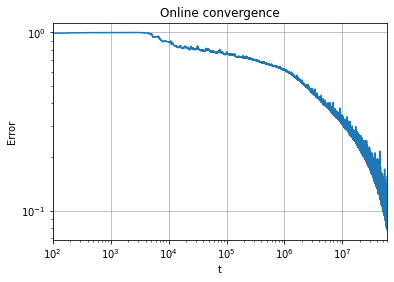

In [28]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.title("Online convergence")
plt.show()

In [33]:
err[-1]

0.08027194784619338

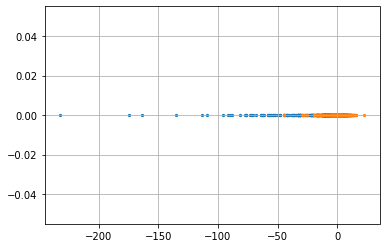

In [31]:
plt.scatter(w.T@y[train_y != 0].T,np.zeros((w.T@y[train_y != 0].T).shape),s=5)
plt.scatter(w.T@y[train_y == 0].T,np.zeros((w.T@y[train_y == 0].T).shape),s=5)
plt.grid()
plt.show()

In [32]:
max(np.sum(w.T@y[train_y != dgt].T > 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T > 1/2 * w.T@(mu_1+mu_2))), np.sum(w.T@y[train_y != dgt].T < 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T < 1/2 * w.T@(mu_1+mu_2))))/y.shape[0]*100

96.93

In [686]:
np.mean(np.sum(y, axis=1)/NKCs)

0.021828756957328388

In [665]:
y.shape

(1078, 5000)